In [1]:
# All Imports

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import random
import time
import pydicom
import glob
from numba import jit
from skimage import filters
import copy
from scipy import ndimage, misc


#import cv2
import sys
import matplotlib.pyplot as plt
import random
#from scipy.misc import imresize

import copy


# GAN model


import matplotlib.pyplot as plt
import sys

#from scipy.misc import imsave
import scipy.stats
from skimage.measure import compare_ssim as ssim
import pydicom
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
from skimage import exposure
import glob
#from scipy.misc import imread
from sklearn.metrics import mean_squared_error
from skimage.measure import compare_psnr
import numpy
from numpy.fft import fft2, ifft2, fftshift
import scipy.ndimage.interpolation as ndii

import torch
import torch.utils.data as data_utils
import torch.optim as optim
from torch.autograd import Variable

import torch.nn as nn

In [60]:
# [STAR] PyTorch models for training the regularizer


class RegCNN(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.out_features = 125
        self.in_features  = 125
        
        self.weight = torch.nn.Parameter(torch.randn(self.out_features, self.in_features))
        self.bias   = torch.nn.Parameter(torch.randn(self.out_features, 1))

    def forward(self, x):
        x = torch.matmul(self.weight, x)
        x = self.bias + x
        x = torch.tanh(x)
        x = torch.mean(x, dim=0)
        return(x)

class RegCNNA(nn.Module):
    def __init__ (self):
        super().__init__()
        
        self.in_features   = 125
        self.out_features1 = 125
        self.out_features2 = 125
        self.out_features3 =   5
        
        self.weight1 = torch.nn.Parameter(torch.randn(self.out_features1, self.in_features))
        self.bias1   = torch.nn.Parameter(torch.randn(self.out_features1, 1))
        
        self.weight2 = torch.nn.Parameter(torch.randn(self.out_features2, self.out_features1))
        self.bias2   = torch.nn.Parameter(torch.randn(self.out_features2, 1))
        
        #self.weight3 = torch.nn.Parameter(torch.randn(self.out_features3, self.out_features2))
        #self.bias3   = torch.nn.Parameter(torch.randn(self.out_features3, 1))

    def forward(self, x):
        x = torch.matmul(self.weight1, x)
        x = self.bias1 + x
        x = torch.tanh(x)
        
        x = torch.matmul(self.weight2, x)
        x = self.bias2 + x
        x = torch.tanh(x)
        
        #x = torch.matmul(self.weight3, x)
        #x = self.bias3 + x
        #x = torch.tanh(x)
        #print(x[124])
        
        x = torch.mean(x, dim=0)
        return x
    
# model  = RegCNNA()
# inx    = torch.tensor(np.random.rand(125, 10).astype('float32'))
# print(inx.shape)
# result = model.forward(inx)
# print(result)

In [41]:
print(result.shape)

AttributeError: 'MaxPool1d' object has no attribute 'shape'

In [2]:
# [STAR] All the paths for training the model

projectionpath        = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'
highprojectionpath    = '/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'
savepath              = '/media/pranjal/newdrive1/DBT-PROJ-DENOISE/'


modelname = "normal-to-three-huber-0.9"

In [4]:
# [STAR] Helper functions for training the de-noising CNN


def bbox2(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def get_crop_image(lowimg, highimg):
    factor = 1
    
    #slice_index = random.randint(0, 24)
    #lowimg  = lowimg[slice_index]
    #highimg = highimg[slice_index]

    thresh  = threshold_otsu(lowimg)
    binary  = lowimg < thresh
    result  = np.multiply(binary, lowimg)

    rmin, rmax, cmin, cmax = bbox2(result)
    resultlowimg = result[rmin:rmax, cmin:cmax]
    resultlowimg = resultlowimg.astype(float)

    result        = np.multiply(binary, highimg)
    resulthighimg = result[rmin:rmax, cmin:cmax]
    resulthighimg = resulthighimg.astype(float)
    
    return resultlowimg, resulthighimg
    
def get_train_data_proj(lowimg, highimg, epoch, batch_size):
    highdose = []
    lowdose  = []
    cliplimit = 0
    
    imgshape = 256
    
    
    # loop till samples of size batch_size with atleast 90% occupancy is not obtained
    crop_count = 0
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    while(crop_count < batch_size):
        cropimgx = random.randint(1, rowst-imgshape)
        cropimgy = random.randint(1, colst-imgshape)
        
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov = np.sum(lowimg_crop > cliplimit)
        # atleast 90% occupancy should be there
        if nonzerov*1.0/(imgshape*imgshape) < 0.65:
            continue
        
        highimg_crop = highimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        #prob = random.randint(0, 100)
        #if prob < 50:
        #    lowimg_crop  = np.fliplr(lowimg_crop)
        #    highimg_crop = np.fliplr(highimg_crop)
        
        #lowimg_crop_mean  = np.mean(lowimg_crop.flatten())
        #highimg_crop_mean = np.mean(highimg_crop.flatten())
        #diff_mean         = highimg_crop_mean -  lowimg_crop_mean
        
        lowdose.append(lowimg_crop)
        highdose.append(highimg_crop)
        
        crop_count = crop_count+1
        
    return np.array(lowdose), np.array(highdose)

def mse(x, y):
    return np.linalg.norm(x - y)

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 200
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    
    cleanimage = np.zeros(limg.shape)
    
    thresh      = threshold_otsu(limg)
    binarymax   = limg > thresh
    
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    restimage   = binarymax#np.multiply(binarymax, limg)
    minvalue    = np.min(limg)
    
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    
    newbinary    = np.multiply(binary, binary1)
    result       = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/(thresh/2)
    lowimg       = resultlowimg-1
    
    #print(np.max(lowimg), np.mean(lowimg), np.min(lowimg), thresh)
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             j = j+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        # If it is not mostly occupied then don't process it
#         if nonzerov*1.0/(imgshape*imgshape) < 0.9:
#             cleanimage[i:i+imgshape, j:j+imgshape] = tempimg
#             i = i+imgshape
#             continue
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = cleanimg[0, :, :, 0]
        i = i+imgshape
    
    halfvalue    = int(imgshape/2)
    quartervalue = int(imgshape/4)#+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(imgshape*imgshape) < 0.5:
#                 cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = tempimg[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
#                 j = j+halfvalue
#                 continue
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            cleanimg    = cleanimg - (after_mean-before_mean)
            
            #print(np.mean(tempimg), np.mean(cleanimg))
            
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = cleanimg[0, :, :, 0][quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]
            j = j+halfvalue
        i = i+halfvalue
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage+1
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    #print(np.max(img_adapteq), np.mean(img_adapteq), np.min(img_adapteq), thresh)
    
    mul_result   = img_adapteq*(thresh/2)
    mul_result   = mul_result+minvalue
    
    #print('restimage max  ', np.max(restimage))
    #print('mul_result max ', np.max(mul_result))
    
    tempvalue = np.min(mul_result)
    #restimage = restimage*np.max(mul_result)
    
    #mul_result   = mul_result + restimage
    #mul_result   = mul_result - tempvalue
    
    #print(mul_result.shape, restimage.shape)
    
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    #print(np.max(mul_result), np.mean(mul_result), np.min(mul_result))
    #print(np.mean(pt2), np.max(pt2), np.min(pt2))
    mul_result   = mul_result.astype(np.uint16)
    #print(np.mean(mul_result), np.max(mul_result), np.min(mul_result))
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    
def test_on_whole_proj(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0.
    
    ds     = pydicom.dcmread(lowfilename)
    limg   = ds.pixel_array
    
    cleanimage = np.zeros(limg.shape)
    
    # get the histogram equalized image
    thresh      = threshold_otsu(limg)
    value_range = thresh - np.min(limg)
    binary  = limg <= thresh
    limg    = limg - np.min(limg)
    binary1 = limg >= 0
    newbinary = np.multiply(binary, binary1)
    result    = np.multiply(newbinary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    resultlowimg = resultlowimg/thresh
    resultlowimg = exposure.equalize_adapthist(resultlowimg, clip_limit=cliplimit)
    lowimg       = resultlowimg
    
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    
    # For bottom row
    i = rowst-128
    j = 0
    while(j+128 < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            j = j+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        j = j+128
    
    # For rightmost column
    j = colst-128
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # For leftmost column
    j = 0
    i = 0
    while(i+128 < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
        nonzerov     = np.sum(lowimg_crop >= cliplimit)    
        # If it is not mostly occupied then don't process it
        if nonzerov*1.0/(128*128) < 0.9:
            cleanimage[i:i+128, j:j+128] = tempimg
            i = i+128
            continue    
        cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
        cleanimage[i:i+128, j:j+128] = cleanimg[0, :, :, 0]
        i = i+128
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+128 < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg      = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            lowimg_crop  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            nonzerov     = np.sum(lowimg_crop >= cliplimit)
            
            # If it is not mostly occupied then don't process it
            if nonzerov*1.0/(128*128) < 0.9:
                cleanimage[i+64:i+128, j+64:j+128] = tempimg[32:96, 32:96]
                j = j+64
                continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            cleanimage[i+64:i+128, j+64:j+128] = cleanimg[0, :, :, 0][32:96, 32:96]
            j = j+64
        i = i+64
    
    #plt.hist(cleanimage.flatten(), bins=256, range=(cliplimit, 1.0), fc='k', ec='k')
    #plt.show()
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq = np.multiply(totalimage, binarynew)
    
    print('value range is ', value_range)
    mul_result   = img_adapteq*value_range
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    mul_result   = mul_result.astype(np.uint16)
    
    
    
    print('Max is ', np.max(mul_result))
    print('Min is ', np.min(mul_result))
    
    max_value = np.max(mul_result)
    mul_result[mul_result == 0] = max_value*2
    
    #plt.hist(mul_result.flatten(), bins=256, range=(np.min(mul_result)+0.01, np.max(mul_result)), fc='k', ec='k')
    #plt.show()
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('\\')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)

def test_on_whole_slice(lowfilename, highfilename, model, xindex, jindex):
    highdose = []
    lowdose  = []
    cliplimit = 0.03
    
    #projindex    = str(slicenum).zfill(2)+'.dcm'
    #lowfilename  = projectionpath+str(filenum)+'_20/_'+projindex
    #highfilename = highprojectionpath+str(filenum)+'_100/_'+projindex
    
    ds     = pydicom.dcmread(lowfilename)
    lowimg = ds.pixel_array
    
    ds      = pydicom.dcmread(highfilename)
    highimg = ds.pixel_array
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg, cliplimit)
    
    totalimage      = []
    totalimagereal  = []
    totalimagerealh = []
    
    rowst = lowimg.shape[0]
    colst = lowimg.shape[1]
    
    print('Shape of Image is ', rowst, 'x', colst)
    
    # Change the indexing later to accomodate the full image view
    # Or second option is to do the averaging at the corner views
    
    # count of processed rows in the whole image
    processed_count_total = 0
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    
    while(i+128 < rowst):
        # for clean image from model
        newrow      = []
        # for the real lowdose image
        newrowreal  = []
        # for the real highdose image
        newrowrealh = []
        # count of images processed in a row
        processed_count_row = 0
        # re-initialize the counter for j
        j = 0
        
        while(j+128 < colst):
            cropimgx = i
            cropimgy = j
                
            tempimg  = lowimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            tempimgh = highimg[cropimgx:cropimgx+128, cropimgy:cropimgy+128]
            
            newrowreal.append(tempimg[32:96, 32:96])
            newrowrealh.append(tempimgh[32:96, 32:96])
            
#             nonzerov = np.sum(lowimg_crop >= cliplimit)
#             # If it is not mostly occupied then don't process it
#             if nonzerov*1.0/(128*128) < 0.9:
#                 newrow.append(tempimg[32:96, 32:96])
#                 processed_count_row = processed_count_row+1
#                 continue
            
            cleanimg = model.generator.predict(np.expand_dims([tempimg], axis=3))
            newrow.append(cleanimg[0, :, :, 0][32:96, 32:96])
            processed_count_row = processed_count_row+1
            
            if i  == (128*xindex) and j == (128*jindex):
                print('Clean Image SNR',    np.mean(cleanimg[0, :, :, 0])/np.std(cleanimg[0, :, :, 0]))
                print('Original Image SNR', np.mean(tempimg)/np.std(tempimg))
                print('HIGH Original Image SNR', np.mean(tempimgh)/np.std(tempimgh))
                
                ssim_low   = ssim(tempimgh, tempimg, data_range=tempimg.max() - tempimg.min())
                ssim_clean = ssim(tempimgh, cleanimg[0, :, :, 0], data_range=cleanimg[0, :, :, 0].max() - cleanimg[0, :, :, 0].min())
                
                print('SSIM low ',   ssim_low)
                print('SSIM clean ', ssim_clean)
                
                mse_clean   = mse(tempimgh, cleanimg[0, :, :, 0])
                mse_low     = mse(tempimgh, tempimg)
                
                print('MSE low ',   mse_low)
                print('MSE clean ', mse_clean)
                
                imsave('testimage.jpg', tempimg)
                imsave('clean2.jpg', cleanimg[0, :, :, 0])
                imsave('low2.jpg',   tempimg)
                imsave('high2.jpg',  tempimgh)
            j = j+64
        i = i+64
                
        combined = np.array(newrow)
        #print('newrow length is ', len(newrow), combined.shape)
        
        combined = np.hstack(combined.reshape(processed_count_row, 64, 64))
        totalimage.append(combined)
        
        combinedreal = np.array(newrowreal)
        combinedreal = np.hstack(combinedreal.reshape(processed_count_row, 64, 64))
        totalimagereal.append(combinedreal)
        
        combinedrealh = np.array(newrowrealh)
        combinedrealh = np.hstack(combinedrealh.reshape(processed_count_row, 64, 64))
        totalimagerealh.append(combinedrealh)
        
        # increment the rows processed count
        processed_count_total = processed_count_total+1
        
        #print('Shape of the combined image is ', combined.shape)
    
    totalimage = np.array(totalimage)
    totalimage = np.vstack(totalimage.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagereal = np.array(totalimagereal)
    totalimagereal = np.vstack(totalimagereal.reshape(processed_count_total, 64, processed_count_row*64))
    
    totalimagerealh = np.array(totalimagerealh)
    totalimagerealh = np.vstack(totalimagerealh.reshape(processed_count_total, 64, processed_count_row*64))
    
    return totalimage, totalimagereal, totalimagerealh

image_indexes_result      = []
temp_image_indexes_result = []

def store_results(epoch, saveseed=5):
    global image_indexes_result
    global temp_image_indexes_result
    
    imgshape = 256
    
    # set the ids for saving the results
    random.seed(saveseed)
    
    projindex    = 55
    lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'
    
    lowimg  = np.fromfile(lowfilename, dtype='float32')
    highimg = np.fromfile(highfilename, dtype='float32')
    lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
    highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
    
    slice_index = 12#random.randint(0, 24)
    lowimg      = lowvol[slice_index]
    highimg     = highvol[slice_index]
    
    # get the cropped image
    lowimg, highimg =  get_crop_image(lowimg, highimg)
    
    r, c = 6, 6
    x, y = get_train_data_proj(lowimg, highimg, 1, 128)
    x = x-0.5
    y = y-0.5
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95)
    plt.tight_layout()
    fig, axs = plt.subplots(r, c, figsize=(30,10))
    cnt      = 0
    
    for i in range(r):
        for j in range(c):
            if len(image_indexes_result) == 0:
                imgindex = random.randint(1, 127)
                temp_image_indexes_result.append(imgindex)
            else:
                imgindex = image_indexes_result[cnt]
            
            cleanimg = aae.generator.predict(np.expand_dims([x[imgindex]], axis=3))
            combined = np.array([x[imgindex]+0.5, cleanimg[0, :, :, 0]+0.5, y[imgindex]+0.5])
            combined = np.hstack(combined.reshape(3,imgshape,imgshape))
            #print(cleanimg[0, :, :, 0].shape, y[imgindex].shape, combined.shape)
            axs[i,j].imshow(combined, cmap='gray')
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i,j].axis('off')
            cnt += 1
    if len(image_indexes_result) == 0:
        image_indexes_result = temp_image_indexes_result
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.savefig(savepath+modelname+"-results/clean_%d.png" % epoch, bbox_inches='tight')
    plt.close()

In [7]:
# [STAR] Model for training the de-noising network

img_shape  = (256, 256, 1)

def huber_loss(y_true, y_pred, clip_delta=0.04):
    error        = y_true - y_pred
    cond         = tf.keras.backend.abs(error) < clip_delta
    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)
    return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

class AdversarialAutoencoder():
    def __init__(self):
        self.optimizer1  = RMSprop(0.0005)
        self.optimizer2  = RMSprop(0.00001)
        
        self.clip_value = 0.01
        
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        
        
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/vanilla-gan-weights-mse-0.1/discriminator_weights_8050.h5')
        self.d_arr = []
        self.g_arr = []
        
        # Build the encoder / decoder
        self.generator = self.build_generator()
         
        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        reconstructed_img            = self.generator(img)
        #self.adversarial_autoencoder = Model(img, reconstructed_img)
        #self.adversarial_autoencoder.compile()
        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False
        
        # The discriminator determines validity of the cleaned image
        validity = self.discriminator(reconstructed_img)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=[huber_loss_mean, 'mse'],
            loss_weights=[0.9, 0.1],
            optimizer=self.optimizer2)
        
        self.discriminator.trainable = True
        self.discriminator.compile(loss='mse',
            optimizer=self.optimizer1, 
            metrics=['accuracy'])
        #self.discriminator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/discriminator_weights_8400.h5')
        #self.generator.load_weights('/media/pranjal/de24af8d-2361-4ea2-a07a-1801b54488d9/DBT_data/Results/gan-proj-mse-0.99-sub-weights/generator_weights_8400.h5')

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_autoencoder(self):
        self.generator.compile(loss=['mse'],optimizer=self.optimizer)
     
    def build_generator(self):
        x = Input(shape=img_shape)
        x1 = Conv2D(32, (3, 3), padding='same')(x)
        x1 = LeakyReLU(alpha=0.2)(x1)
        
        x2 = Conv2D(64, (3, 3), padding='same')(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        
        x3 = Conv2D(64, (3, 3), padding='same')(x2)
        #x3 = BatchNormalization(momentum=0.8)(x3)
        x3 = LeakyReLU(alpha=0.2)(x3)
        
        #x3_m = merge([x2, x3], mode='concat', concat_axis=3)
        x4 = Conv2D(64, (3, 3), padding='same')(x3)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2)(x4)
        #x6_i = merge([x2, x6], mode='concat', concat_axis=3)
        
        
        x5 = Conv2D(128, (3, 3), padding='same')(x4)\
        #x5 = BatchNormalization(momentum=0.8)(x5)
        x5 = LeakyReLU(alpha=0.2)(x5)
        
        #x7_i = merge([x1, x7], mode='concat', concat_axis=3)
        x6 = Conv2D(128, (3, 3), padding='same')(x5)
        x6 = LeakyReLU(alpha=0.2)(x6)
        
        x7 = Conv2D(64, (3, 3), padding='same')(x6)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x7 = LeakyReLU(alpha=0.2)(x7)
        #x7_m = merge([x1, x6], mode='concat', concat_axis=3)
        #x8    = Conv2D(1, (3, 3), activation='relu', padding='same')(x6)
        x8 = Conv2D(1, (3, 3), padding='same')(x7)
        x8 = LeakyReLU(alpha=0.2)(x8)
        
        out = keras.layers.Subtract()([x, x8])
        #out = ReLU()(out)
        model = Model(x, out)
        return model

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64,  (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(64, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        #         model.add(Conv2D(16, (6, 6),  strides=(2, 2)))
        #         model.add(LeakyReLU(alpha=0.2))
        #         model.add(Dropout(0.5))
        model.add(Conv2D(64, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Conv2D(128, (3, 3)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(128, (3, 3),  strides=(2, 2)))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.25))
        model.add(Dense(1))
        return model
    
    def train_generator_autoencoder(self, epochs, batch_size=128):
        for epoch in range(epochs):
            # Load the dataset
            X_train, Y_train = get_train_data(epoch, batch_size)
            
            X_train = np.expand_dims(X_train, axis=3)
            Y_train = np.expand_dims(Y_train, axis=3)
            
            g_loss = self.generator.train_on_batch(X_train, Y_train)
            
            # Plot the progress
            print ("Epoch ", epoch, " G loss ", g_loss)
            if epoch%50 == 0:
                store_results(epoch)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
    
    def train(self, epochs, batch_size=128, sampling=50, saveseed=5, startepoch=0, discriminator_epochs=5):
        for epoch in range(startepoch, epochs):
            # Train the discriminator 5 times
            #print('Training Discriminator ', epoch)
            
            projindex = str(random.randint(43, 68))#+'.dcm'
    
            lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
            highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

            lowimg  = np.fromfile(lowfilename, dtype='float32')
            highimg = np.fromfile(highfilename, dtype='float32')
            
            lowvol  = np.reshape(lowimg,  [25, 1600, 3200])/1250.0
            highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0
            
            for itd in range(discriminator_epochs):
                slice_index = random.randint(0, 24)
                lowimg      = lowvol[slice_index]
                highimg     = highvol[slice_index]
                
                # get the cropped image
                lowimg, highimg =  get_crop_image(lowimg, highimg)
                
                # Load the dataset
                X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
                X_train = X_train - 0.5
                Y_train = Y_train - 0.5
                
                #print(X_train.shape, Y_train.shape)
                
                X_train = np.expand_dims(X_train, axis=3)
                Y_train = np.expand_dims(Y_train, axis=3)

                # Adversarial ground truths
                valid = np.ones((batch_size, 1))
                fake  = np.zeros((batch_size, 1))

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # get the noisy image and feed it into the generator
                X_train_clean = self.generator.predict(X_train)

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(Y_train, valid)
                d_loss_fake = self.discriminator.train_on_batch(X_train_clean, fake)
                d_loss      = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            #print('Training Generator ', epoch)
            # ---------------------
            #  Train Generator
            # ---------------------
            # Train the generator
            g_loss = self.adversarial_autoencoder.train_on_batch(X_train, [Y_train, valid])
            #print('g_loss ', g_loss)
            self.d_arr.append(d_loss)
            self.g_arr.append(g_loss)
            
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' D loss real ', -d_loss_real, ' D loss fake ', d_loss_fake, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            # Plot the progress
            #print ("%d [D loss: %f] [G loss: %f] [G loss: %f %f]" % (epoch, 1 - d_loss, 1 - g_loss[0], g_loss[0], g_loss[1]))
            #print('Epoch ', epoch, ' Total D loss ', -d_loss, ' G_loss ', g_loss[0], g_loss[1], g_loss[2])
            
            if epoch%sampling == 0:
                store_results(epoch, saveseed)
                self.generator.save_weights(savepath+modelname+'-weights/generator_weights_'+str(epoch)+'.h5')
                #self.discriminator.save_weights(savepath+modelname+'-weights/discriminator_weights_'+str(epoch)+'.h5')
            
            print ("%d [D loss: %f, mean_acc: %.2f%% real_acc: %.2f%% fake_acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], 100*d_loss_real[1], 100*d_loss_fake[1], g_loss[2]*0.0001, g_loss[1]*0.999))

In [8]:
# [STAR] Training loop of the model

aae = AdversarialAutoencoder()
# print(aae.generator.summary())
# print(aae.discriminator.summary())

In [ ]:
aae.train(epochs=25000, batch_size=32, sampling=50, saveseed=7590, startepoch=0)

In [ ]:
# [STAR] For denoising the projections of dicom files
from skimage.filters import unsharp_mask, threshold_local, threshold_minimum

def test_on_whole_proj_200(lowfilename, model):
    highdose = []
    lowdose  = []
    cliplimit = 0
    imgshape  = 256
    
    ds             = pydicom.dcmread(lowfilename)
    limg           = ds.pixel_array
    original_image = copy.deepcopy(limg)
    
    cleanimage        = np.zeros(limg.shape)
    thresh            = threshold_otsu(limg)
    
    outsideimage_mask = limg > thresh
    insideimage_mask  = limg < thresh
    
    binary  = limg <= thresh
    
    result       = np.multiply(binary, limg)
    resultlowimg = result
    resultlowimg = resultlowimg.astype(float)
    lowimg       = resultlowimg
    
    # Perform sharpening before de-noising
    #lowimg = unsharp_mask(lowimg, radius=3, amount=0.5, preserve_range=True)
    
    print(np.min(resultlowimg.flatten()), np.max(resultlowimg.flatten()))
    rowst = limg.shape[0]
    colst = limg.shape[1]
    
    # For top row
    i = 0
    j = 0
    while(j+imgshape < colst):
        cropimgx     = i
        cropimgy     = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        #cleanimg    = cleanimg*3750.0
        
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    
    # For bottom row
    i = rowst-imgshape
    j = 0
    while(j+imgshape < colst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        j = j+imgshape
    
    # For rightmost column
    j = colst-imgshape
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    # For leftmost column
    j = 0
    i = 0
    while(i+imgshape < rowst):
        cropimgx = i
        cropimgy = j
        tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 - 0.5
        lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
        nonzerov     = np.sum(lowimg_crop > cliplimit)    
        
        before_mean = np.mean(tempimg)
        cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
        after_mean  = np.mean(cleanimg)
        #cleanimg    = cleanimg + before_mean
        cleanimg    = cleanimg - (after_mean-before_mean)
        
        cleanimage[i:i+imgshape, j:j+imgshape] = (cleanimg[0, :, :, 0]+0.5)*1250
        i = i+imgshape
    
    halfvalue    = int(imgshape/2) # replacement size
    quartervalue = int(imgshape/4) # stride size 
    #+int(imgshape/2)
    
    # indexes for deciding the patch location
    i = 0 
    j = 0
    while(i+imgshape < rowst):
        # re-initialize the counter for j
        j = 0
        while(j+imgshape < colst):
            cropimgx = i
            cropimgy = j
            
            tempimg      = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]/1250.0 -0.5
            lowimg_crop  = lowimg[cropimgx:cropimgx+imgshape, cropimgy:cropimgy+imgshape]
            nonzerov     = np.sum(lowimg_crop > cliplimit)
            
            before_mean = np.mean(tempimg)
            cleanimg    = model.generator.predict(np.expand_dims([tempimg], axis=3))
            after_mean  = np.mean(cleanimg)
            #cleanimg    = cleanimg + before_mean
            cleanimg    = cleanimg - (after_mean-before_mean)
            #cleanimg[cleanimg < 0] = 0
            #print(after_mean, before_mean)
            cleanimage[i+quartervalue:i+quartervalue+halfvalue, j+quartervalue:j+quartervalue+halfvalue] = (cleanimg[0, :, :, 0]+0.5)[quartervalue:quartervalue+halfvalue, quartervalue:quartervalue+halfvalue]*1250
            #j = j+halfvalue
            j = j+quartervalue
        #i = i+halfvalue
        i = i+quartervalue
    
#     savename = lowfilename.split('/')[-1]
#     savepath = cleanprojpath+savename+'.npy'
#     np.save(savepath, cleanimage)
    
    #cleanimage[cleanimage < 0] = 0
    #cleanimage[cleanimage > 2000] = 2000
    
    totalimage  = cleanimage
    binarynew   = binary
    
    img_adapteq  = np.multiply(totalimage, binarynew)
    mul_result   = img_adapteq
    
    # Adding the Code to replace the oustide breast region with original values
    mul_result     = mul_result*insideimage_mask        # Get the inside region only
    mul_result[mul_result < 0] = 0
    print(np.min(mul_result.flatten()), np.max(mul_result.flatten()), mul_result.dtype, cleanimage.dtype, cleanimg.dtype)
    
    original_image = original_image*outsideimage_mask   # Get the outside region only
    mul_result     = mul_result+original_image 
    
    
    mul_result   = mul_result.astype(np.uint16)
    
    ds.PixelData = mul_result.tostring()
    
    savename = lowfilename.split('/')[-1]
    savepath = cleanprojpath+savename
    ds.save_as(savepath)
    


lowprojpath   = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC/'
cleanprojpath = '/media/pranjal/newdrive1/REAL-DBT-PROJECTIONS/Pranjal-PMA-DATA/04140608/LE-L-CC-CLEAN1-750-HUBER/'

#/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights

aae = AdversarialAutoencoder()
aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-huber-0.9-weights/generator_weights_750.h5')
#aae.generator.load_weights('/media/pranjal/newdrive1/DBT-PROJ-DENOISE/normal-to-three-0.99-weights/generator_weights_400.h5')

files = glob.glob(lowprojpath+'*.IMA')

for f in files:
    print(f)
    test_on_whole_proj_200(f, aae)
    
    
#tensorflow.keras.losses.Huber(delta=1.5)
#tf.keras.losses.

In [ ]:
projindex = str(random.randint(43, 68))#+'.dcm'
epoch = 0
batch_size = 32

lowfilename  = projectionpath+'3200x1600x25.'+str(projindex)+'.raw'
highfilename = highprojectionpath+'3200x1600x25.'+str(projindex)+'.raw'

lowimg  = np.fromfile(lowfilename, dtype='float32')
highimg = np.fromfile(highfilename, dtype='float32')

lowvol  = np.reshape(lowimg, [25, 1600, 3200])/1250.0
highvol = np.reshape(highimg, [25, 1600, 3200])/3750.0


slice_index = random.randint(0, 24)
lowimg      = lowvol[slice_index]
highimg     = highvol[slice_index]

# get the cropped image
lowimg, highimg =  get_crop_image(lowimg, highimg)

# Load the dataset
X_train, Y_train = get_train_data_proj(lowimg, highimg, epoch, batch_size)
X_train  = X_train  - 0.5
Y_train  = Y_train  - 0.5


print(X_train.shape, Y_train.shape)

In [5]:
# [STAR] For generating the projections

@jit(nopython=True, parallel=True)
def my_divide(x, y):
    return np.divide(x, y)

@jit(nopython=True, parallel=True)
def my_add(x, y):
    return np.add(x, y)

@jit(nopython=True, parallel=True)
def my_mul(x, y):
    return np.multiply(x, y)




#testvol = ndimage.zoom(testvol, 0.25, order=1)
#testvol = np.zeros([320, 448, 800], dtype='uint8')

scaling_factor = 1

SOD       = 65/0.025
ODD       = 4.5/0.025
detWidth  = 0.0085/0.025 #/(0.0255/scaling_factor)   # size of each detector pixel
detHeight = detWidth        # size of each detector pixel
detRows   = 3584
detCols   = 1600


num_angles = 25

#estimate = np.fromfile("/media/pranjal/2d33dff3-95f7-4dc0-9842-a9b18bcf1bf9/pranjal/DBT_data/ClinicalExample/CE-05_R/ce.800x448x320.05-le.raw", dtype='float32')
#estimate = np.reshape(estimate, [320, 448, 800])


a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/1.mat")["head"]
testvol = np.rollaxis(a, 2, 0)
testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
testvol = testvol/65.0


vol_geom = astra.create_vol_geom(int(testvol.shape[1]), int(testvol.shape[2]), int(testvol.shape[0]))
proj_arr = np.zeros((num_angles, detCols, detRows), dtype='float16')
testones = np.ones([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])],  dtype='uint8')
estimate = np.zeros([int(testvol.shape[0]), int(testvol.shape[1]), int(testvol.shape[2])], dtype='float16')

print('Starting Recon')


#proj_arr = np.array(proj_arr).astype('float16')
#proj_arr = np.rollaxis(proj_arr, 1, 0)
#proj_arr = proj_arr.flatten()


# All Flags
recon_type       = 0
use_old_calci    = 0 # Use already generated calcifications
save_projections = 1 # Save the projections
insert_noise     = 1


triple_dose  = True
quarter_dose = False
normal_dose  = False

# SIRT iteration LOOP
if recon_type == 0:
    niter      = 10
    start_time = time.time()
    
    for index in range(68, 69):
        print("Phantom ", index)
        a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
        testvol = np.rollaxis(a, 2, 0)
        testvol = np.moveaxis(testvol, [0, 1, 2], [0, 2, 1])
        volume_mask = testvol > 0
        
        testvol = np.multiply(volume_mask, testvol)
        testvol = testvol/65.0
        
        ang = []
        for i in range(num_angles):
            ang.append(1.9)
        start_angle = -25#+np.random.randint(0, 3)
        theta       = []
        for i in range(num_angles):
            theta.append(start_angle*np.pi/180.0)
            start_angle = start_angle+ang[i]
        
        vectors = np.zeros((len(theta), 12))
        
        # For reconstructing real data
        vectors[:, 0:3]  = np.transpose(np.array([np.sin(theta), np.zeros(len(theta)), np.cos(theta)])) * SOD        # S source to object
        vectors[:,3:6]   = np.transpose(np.array([np.zeros(len(theta)), np.zeros(len(theta)),  -np.ones(len(theta))*ODD]))             # D object to detector
        vectors[:,6:9]   = np.transpose(np.array([np.ones(len(theta))*detWidth, np.zeros(len(theta)), np.zeros(len(theta))]))         # U
        vectors[:,9:12]  = np.transpose(np.array([np.zeros(len(theta)), np.ones(len(theta))*detWidth, np.zeros(len(theta))]))        # V

        # Creating the projection matrix
        proj_geom        = astra.create_proj_geom('cone_vec', detCols, detRows, vectors)
        proj_id          = astra.create_projector('cuda3d',   proj_geom, vol_geom)
        W                = astra.OpTomo(proj_id)
        
        proj_arr         = W*testvol
        
        temp_proj = np.reshape(proj_arr, [detCols, num_angles, detRows])
        temp_proj = np.rollaxis(temp_proj, 0, 2)
        
        if triple_dose:
            I0        = 6000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/DOUBLE/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if normal_dose:
            I0        = 2000
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            np.array(proj_noi).astype('float32').tofile(fid)
            #np.array(g_noi).astype('float32').tofile(fid)
        
        if(quarter_dose):
            I0        = 500
            proj      = I0*np.exp(-temp_proj)
            proj_noi  = np.random.poisson(proj)
            proj_noi[proj_noi == 0] = 1
            
            g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            g_noi[g_noi < 0]        = 0
            
            fid = open('/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[1])+'x'+str(temp_proj.shape[0])+'.'+str(index)+'.raw', 'w')
            #np.array(proj_noi).astype('float32').tofile(fid)
            np.array(g_noi).astype('float32').tofile(fid)
        
            #g_noi                   = np.log(I0) - np.log(proj_noi) # convert back to line integrals 
            #g_noi[g_noi < 0]        = 0
            #proj_arr = proj_noi#g_noi
        
#         temp_proj  = np.reshape(proj_arr, [detCols, num_angles, detRows])
#         temp_proj1 = temp_proj[:, 15:-15, :]
        
#         # Saving the Projections
#         if save_projections:
#             fid = open('/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/QUARTER/'+str(temp_proj.shape[2])+'x'+str(temp_proj.shape[0])+'x'+str(temp_proj.shape[1])+'.'+str(index)+'.raw', 'w')
#             temp_proj  = np.rollaxis(temp_proj, 0, 2)
#             np.array(temp_proj).astype('float32').tofile(fid)
        

Starting Recon
Phantom  68


In [1]:
import numpy as np
index = 68
all_proj = np.fromfile("/media/pranjal/cewitdata1/DBT-PROJ-DENOISE/NORMAL/3200x1600x25."+str(index)+".raw", dtype='float32')
all_proj = np.reshape(all_proj, [25, 1600, 3200])
                      
print(all_proj.shape)

(25, 1600, 3200)


In [6]:
a       = sio.loadmat("/media/pranjal/cewitdata2/DBT-PROJ-DENOISE/attenuation_values_cropped/LE/"+str(index)+".mat")["head"]
print(a.shape)        

(800, 448, 320)


In [82]:
# [STAR] Code to read the data

a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/MC_CE27_slice32_atzz666_dense_uppaddle_pc_209923395_crop_1073x2748x816.raw', dtype='uint8')
a = np.reshape(a, [816, 2748, 1073])

print(a.shape)

temp = a[666]

(816, 2748, 1073)


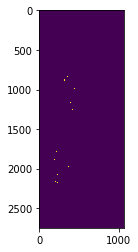

In [83]:
temp[temp != 250] = 0
plt.imshow(temp)

(750, 350)


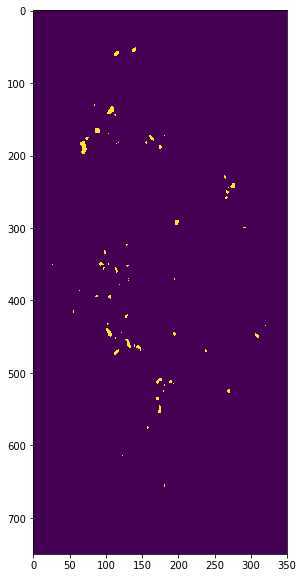

In [84]:
plt.figure(figsize=(20,10))
temp1 = temp[700:1450, 250:600]
print(temp1.shape)
plt.imshow(temp1)

In [77]:
np.save('calcification_cluster.npy', temp1)

(1140, 2415, 1740)


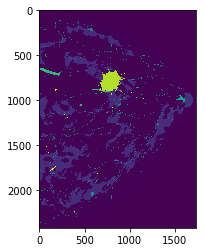

In [3]:
a = np.fromfile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop.raw', dtype='uint8')
a = np.reshape(a, [1140, 2415, 1740])
#  1740   2415   1140

print(a.shape)

#temp = a[666]
plt.imshow(a[500])

In [4]:
temp1 = np.load('calcification_cluster.npy')
print(temp1.shape)

(750, 350)


In [89]:
a1    = a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]]
temp1[temp1 != 250] = a1[temp1 != 250]

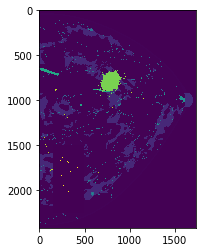

In [6]:
#a[499, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[500, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1
#a[501, 1500:1500+temp1.shape[0], 150:150+temp1.shape[1]] =  temp1

plt.imshow(a[501])

In [7]:
a.tofile('/media/pranjal/cewitdata1/pranjal/CT-RECON-DATA/pcl_22183101_crop_calci.raw')

In [641]:
e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

temp               = e[27]#, 900:1150, 950:1350]
temp[temp < 0.03] = 0
temp[temp > 0.03] = 1
#plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
print(a.shape, b.shape, e.shape)

(858161,) (858161,)
(58, 1200, 3000) (58, 1200, 3000) (58, 1200, 3000)


(858161,) (858161,)
85793 85793 858161
(85793, 125) (85793,)


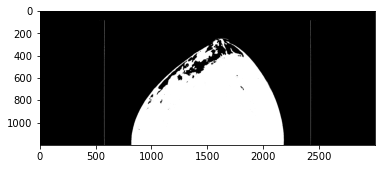

In [12]:
# [STAR] For creating the dataset to train the potential function

e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.4_4_0.0005_-0.5_1_anistropic_three_1.raw', dtype='float32')
e = np.reshape(e, [58, 1200, 3000])

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_normal8_1.raw', dtype='float32')
#a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0.5_1_anistropic_normalmlp1_1.raw', dtype='float32')
#a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_0_0.0005_0.5_1_anistropic_normalmlp1_1.raw', dtype='float32')
a = np.reshape(a, [58, 1280, 3200])

#b = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_normal_1.raw', dtype='float32')
#b = np.reshape(b, [58, 1200, 3000])

#c = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3000x1200x58.0_1_0.0005_0_1_anistropic_three_1.raw', dtype='float32')
#c = np.reshape(c, [58, 1200, 3000])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_-0.1_1_anistropic_three8_1.raw', dtype='float32')
d = np.reshape(d, [58, 1280, 3200])

#temp1 = a[:, 900:1150, 950:1350]
#D2    = d[:, 900:1150, 950:1350]

Y_array = d
X_array = a


# For getting the locations of the training data points

temp               = e[27]#, 900:1150, 950:1350]
temp[temp < 0.03] = 0
temp[temp > 0.03] = 1

#temp[temp < 0.045] = 0
plt.imshow(temp, cmap='gray')

non_zero_index = np.nonzero(temp)

print(non_zero_index[0].shape, non_zero_index[1].shape)
#print(a.shape, b.shape, e.shape)


# Generate the samples for the Regression Model

X      = []
Y      = []
voxels = 5


for i in range(non_zero_index[0].shape[0]):
    if np.random.rand() > 0.1:
        continue
    
    ind_z = random.randint(15, 45)
    ind_y = non_zero_index[0][i]
    ind_x = non_zero_index[1][i]
    
    tx = X_array[ind_z-2:ind_z+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
    ty = Y_array[ind_z,           non_zero_index[0][i], non_zero_index[1][i]]
    
    if len(tx.flatten()) ==  voxels*voxels*voxels:
        X.append(tx - X_array[ind_z, non_zero_index[0][i], non_zero_index[1][i]])
        Y.append(ty)

print(len(X), len(Y), non_zero_index[0].shape[0])

X =  np.array(X)
X =  np.reshape(X, [X.shape[0], voxels*voxels*voxels])
Y =  np.array(Y)
#Y =  np.reshape(Y, [Y.shape[0], 1])

print(X.shape, Y.shape)

In [ ]:
# Duplicate Code

X = []
Y = []
voxels = 5


for i in range(non_zero_index[0].shape[0]):
    ind_z = 27
    ind_y = non_zero_index[0][i]
    ind_x = non_zero_index[1][i]
    
    if ind_y+2 < X_array.shape[1] and ind_x+2 < X_array.shape[2] and ind_y-2 >= 0 and ind_x-2 >= 0:
        #tx  = []
        #for ind_nr_z  in range(ind_z-2, ind_z+3):
        #    for ind_nr_y in range(ind_y-2, ind_y+3):
        #        for ind_nr_x in range(ind_x-2, ind_x+3):
        #            tx.append(X_array[ind_nr_z][ind_nr_y][ind_nr_x])

        tx = X_array[27-2:27+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
        ty = Y_array[27, non_zero_index[0][i], non_zero_index[1][i]]
        
        if len(tx.flatten()) ==  voxels*voxels*voxels:
            X.append(tx)
            Y.append(ty)
        
        tx = X_array[40-2:40+3, non_zero_index[0][i]-2:non_zero_index[0][i]+3, non_zero_index[1][i]-2:non_zero_index[1][i]+3]
        ty = Y_array[40, non_zero_index[0][i], non_zero_index[1][i]]
        
        if len(tx.flatten()) ==  voxels*voxels*voxels:
            X.append(tx)
            Y.append(ty)

print(len(X), len(Y), non_zero_index[0].shape[0])

X =  np.array(X)
X =  np.reshape(X, [X.shape[0], voxels*voxels*voxels])
Y =  np.array(Y)
#Y =  np.reshape(Y, [Y.shape[0], 1])

print(X.shape, Y.shape)

In [30]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    print('classname is ', classname)
    
    # for every Linear layer in a model..
    #if classname.find('Linear') != -1:
    # apply a uniform distribution to the weights and a bias=0
    m.weight1.data.uniform_(0.0, 0.03)
    m.bias1.data.data.uniform_(0.0, 0.03)#.fill_(0)
    
    m.weight2.data.uniform_(0.0, 0.03)
    m.bias2.data.data.uniform_(0.0, 0.03)#.fill_(0)

weights_init_uniform(model)

classname is  RegCNNA


In [63]:
# For training the Regression Model using PyTorch

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

device         = torch.device("cuda:0")

#model  = RegCNNA()
#weights_init_uniform(model)
#model.cuda()


criterion          = nn.L1Loss(reduce=False, )#.MSELoss()
optimizer_student  = optim.Adam(model.parameters(), lr=0.001)#, weight_decay=0.1)

def evaluate_result(model, valx, valy):
    model.eval()
    
    val_dice       = []
    batch_size     = 1
    for ik in range(len(valx)//batch_size):
        x = valx[ik*batch_size:(ik+1)*batch_size, :].T
        y = valy[ik*batch_size:(ik+1)*batch_size]

        x = torch.tensor(x, device=device).float()

        output = model.forward(x)
        output = output.data.cpu().numpy()
        
        dt = np.abs(y - output)
        dt = np.mean(dt)
        
        val_dice.append(dt)
    return val_dice

def train_model(model, batch_size, optimizer, criterion, trainx, trainy):
    loss_array = []
    
    model.train()
    
    for i in range(len(trainx)//batch_size):
        x = trainx[i*batch_size:(i+1)*batch_size, :].T
        y = trainy[i*batch_size:(i+1)*batch_size]
        
        x = torch.tensor(x, device=device).float()
        y = torch.tensor(y, device=device).float()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss   = criterion(output , y)
        #print(i, output.shape, loss.shape, y.shape)
        loss   = torch.mean(loss)
        loss.backward()
        
        loss_array.append(loss.item())
        optimizer.step()
    
    loss_array = np.mean(loss_array)
    return loss_array


#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


for i in range(50000):
    index = np.random.permutation(len(X_train))
    
    X_train = X_train[index]
    y_train = y_train[index]
    
    train_model(model, 10, optimizer_student, criterion, X_train, y_train)
    result = evaluate_result(model, X_test, y_test)
    
    print(i, 'Validation Accuracy ', np.mean(result))

0 Validation Accuracy  0.005327893
1 Validation Accuracy  0.0053231427
2 Validation Accuracy  0.005316558
3 Validation Accuracy  0.0053139436
4 Validation Accuracy  0.0053544887
5 Validation Accuracy  0.0053215404
6 Validation Accuracy  0.005312706
7 Validation Accuracy  0.005312646
8 Validation Accuracy  0.005322423
9 Validation Accuracy  0.0053177895
10 Validation Accuracy  0.005324006
11 Validation Accuracy  0.005319533
12 Validation Accuracy  0.005324627
13 Validation Accuracy  0.0053194696
14 Validation Accuracy  0.005329172
15 Validation Accuracy  0.0053274883
16 Validation Accuracy  0.005307384
17 Validation Accuracy  0.0053091226
18 Validation Accuracy  0.0053235255
19 Validation Accuracy  0.0053067394
20 Validation Accuracy  0.0053063403
21 Validation Accuracy  0.005308097
22 Validation Accuracy  0.0053449348
23 Validation Accuracy  0.005305131
24 Validation Accuracy  0.0053121173
25 Validation Accuracy  0.0053213676
26 Validation Accuracy  0.0053108037
27 Validation Accuracy 

222 Validation Accuracy  0.0052950885
223 Validation Accuracy  0.0053049196
224 Validation Accuracy  0.0052882344
225 Validation Accuracy  0.005294638
226 Validation Accuracy  0.005289486
227 Validation Accuracy  0.0052945763
228 Validation Accuracy  0.0053236014
229 Validation Accuracy  0.0052943695
230 Validation Accuracy  0.005292884
231 Validation Accuracy  0.005283036
232 Validation Accuracy  0.005319365
233 Validation Accuracy  0.0052849613
234 Validation Accuracy  0.0052957307
235 Validation Accuracy  0.0053265276
236 Validation Accuracy  0.005307883
237 Validation Accuracy  0.005317244
238 Validation Accuracy  0.0052933563
239 Validation Accuracy  0.005303171
240 Validation Accuracy  0.005302309
241 Validation Accuracy  0.0052920203
242 Validation Accuracy  0.0052969926
243 Validation Accuracy  0.0053103245
244 Validation Accuracy  0.005293483
245 Validation Accuracy  0.005298092
246 Validation Accuracy  0.005294282
247 Validation Accuracy  0.0052908496
248 Validation Accuracy 

441 Validation Accuracy  0.005279445
442 Validation Accuracy  0.0052802176
443 Validation Accuracy  0.0052710385
444 Validation Accuracy  0.005275829
445 Validation Accuracy  0.0052822074
446 Validation Accuracy  0.0052852994
447 Validation Accuracy  0.0052766856
448 Validation Accuracy  0.0052785743
449 Validation Accuracy  0.0053060935
450 Validation Accuracy  0.0052745785
451 Validation Accuracy  0.0052967356
452 Validation Accuracy  0.0052757636
453 Validation Accuracy  0.0052789813
454 Validation Accuracy  0.00528801
455 Validation Accuracy  0.005275516
456 Validation Accuracy  0.0052830256
457 Validation Accuracy  0.005277991
458 Validation Accuracy  0.0052769445
459 Validation Accuracy  0.005272307
460 Validation Accuracy  0.0052785906
461 Validation Accuracy  0.0052730856
462 Validation Accuracy  0.0053016716
463 Validation Accuracy  0.005277112
464 Validation Accuracy  0.0052920966
465 Validation Accuracy  0.0052900813
466 Validation Accuracy  0.005285658
467 Validation Accura

660 Validation Accuracy  0.005252137
661 Validation Accuracy  0.0052696615
662 Validation Accuracy  0.0052612834
663 Validation Accuracy  0.0052578305
664 Validation Accuracy  0.005250955
665 Validation Accuracy  0.0052458076
666 Validation Accuracy  0.0052564396
667 Validation Accuracy  0.0052485866
668 Validation Accuracy  0.005270892
669 Validation Accuracy  0.005240673
670 Validation Accuracy  0.0052447747
671 Validation Accuracy  0.0052839904
672 Validation Accuracy  0.0052514174
673 Validation Accuracy  0.0052472143
674 Validation Accuracy  0.0052385074
675 Validation Accuracy  0.0052448185
676 Validation Accuracy  0.0052424176
677 Validation Accuracy  0.0052657914
678 Validation Accuracy  0.005243558
679 Validation Accuracy  0.0052508023
680 Validation Accuracy  0.0052517746
681 Validation Accuracy  0.0052406634
682 Validation Accuracy  0.0052419594
683 Validation Accuracy  0.0052405978
684 Validation Accuracy  0.0052456385
685 Validation Accuracy  0.005242374
686 Validation Acc

879 Validation Accuracy  0.005185219
880 Validation Accuracy  0.005180215
881 Validation Accuracy  0.005184442
882 Validation Accuracy  0.005192219
883 Validation Accuracy  0.0051910644
884 Validation Accuracy  0.005184631
885 Validation Accuracy  0.0051855096
886 Validation Accuracy  0.005191945
887 Validation Accuracy  0.00518263
888 Validation Accuracy  0.005200372
889 Validation Accuracy  0.005192362
890 Validation Accuracy  0.005178273
891 Validation Accuracy  0.005206342
892 Validation Accuracy  0.005187531
893 Validation Accuracy  0.005189308
894 Validation Accuracy  0.0052058934
895 Validation Accuracy  0.0051920703
896 Validation Accuracy  0.005199748
897 Validation Accuracy  0.0051858546
898 Validation Accuracy  0.0051912633
899 Validation Accuracy  0.0051848395
900 Validation Accuracy  0.0051783863
901 Validation Accuracy  0.0052023074
902 Validation Accuracy  0.0051871487
903 Validation Accuracy  0.0051890644
904 Validation Accuracy  0.005175865
905 Validation Accuracy  0.0

1095 Validation Accuracy  0.0036238655
1096 Validation Accuracy  0.0036312002
1097 Validation Accuracy  0.0036547037
1098 Validation Accuracy  0.0036257647
1099 Validation Accuracy  0.0036235864
1100 Validation Accuracy  0.0036625166
1101 Validation Accuracy  0.003607367
1102 Validation Accuracy  0.0036284847
1103 Validation Accuracy  0.003710216
1104 Validation Accuracy  0.0035891505
1105 Validation Accuracy  0.003609268
1106 Validation Accuracy  0.0035879447
1107 Validation Accuracy  0.003601323
1108 Validation Accuracy  0.0035978032
1109 Validation Accuracy  0.0035663957
1110 Validation Accuracy  0.0036013108
1111 Validation Accuracy  0.0035767357
1112 Validation Accuracy  0.0035772687
1113 Validation Accuracy  0.0035858867
1114 Validation Accuracy  0.0035842508
1115 Validation Accuracy  0.0035758666
1116 Validation Accuracy  0.0035644895
1117 Validation Accuracy  0.0035669315
1118 Validation Accuracy  0.0035839558
1119 Validation Accuracy  0.003563875
1120 Validation Accuracy  0.00

1307 Validation Accuracy  0.0033553946
1308 Validation Accuracy  0.003355101
1309 Validation Accuracy  0.003359039
1310 Validation Accuracy  0.0033404406
1311 Validation Accuracy  0.0034039824
1312 Validation Accuracy  0.003380769
1313 Validation Accuracy  0.0034073617
1314 Validation Accuracy  0.0033841403
1315 Validation Accuracy  0.0033755424
1316 Validation Accuracy  0.0033401588
1317 Validation Accuracy  0.0033581462
1318 Validation Accuracy  0.0033792409
1319 Validation Accuracy  0.0033766048
1320 Validation Accuracy  0.0033567105
1321 Validation Accuracy  0.0033737344
1322 Validation Accuracy  0.0033670973
1323 Validation Accuracy  0.0033529697
1324 Validation Accuracy  0.0033775996
1325 Validation Accuracy  0.0033890984
1326 Validation Accuracy  0.003356861
1327 Validation Accuracy  0.0033544095
1328 Validation Accuracy  0.003359506
1329 Validation Accuracy  0.0033534307
1330 Validation Accuracy  0.0033725807
1331 Validation Accuracy  0.003383328
1332 Validation Accuracy  0.003

1519 Validation Accuracy  0.0032957662
1520 Validation Accuracy  0.0032277578
1521 Validation Accuracy  0.0032221791
1522 Validation Accuracy  0.0032791458
1523 Validation Accuracy  0.003221081
1524 Validation Accuracy  0.0032143923
1525 Validation Accuracy  0.0033292077
1526 Validation Accuracy  0.0032099131
1527 Validation Accuracy  0.0032384922
1528 Validation Accuracy  0.0032053546
1529 Validation Accuracy  0.00321241
1530 Validation Accuracy  0.0032509107
1531 Validation Accuracy  0.0032173658
1532 Validation Accuracy  0.003202134
1533 Validation Accuracy  0.0032288348
1534 Validation Accuracy  0.0032384903
1535 Validation Accuracy  0.0031968504
1536 Validation Accuracy  0.0032135495
1537 Validation Accuracy  0.0032149036
1538 Validation Accuracy  0.0032416421
1539 Validation Accuracy  0.003227277
1540 Validation Accuracy  0.0032337136
1541 Validation Accuracy  0.0032295305
1542 Validation Accuracy  0.0032375567
1543 Validation Accuracy  0.0032446901
1544 Validation Accuracy  0.00

1731 Validation Accuracy  0.003178491
1732 Validation Accuracy  0.0031663382
1733 Validation Accuracy  0.003164548
1734 Validation Accuracy  0.0031547633
1735 Validation Accuracy  0.0031594194
1736 Validation Accuracy  0.0031627328
1737 Validation Accuracy  0.003160354
1738 Validation Accuracy  0.003177466
1739 Validation Accuracy  0.0031811537
1740 Validation Accuracy  0.0031875481
1741 Validation Accuracy  0.0032117818
1742 Validation Accuracy  0.0031858382
1743 Validation Accuracy  0.0032146114
1744 Validation Accuracy  0.0031589258
1745 Validation Accuracy  0.0032375737
1746 Validation Accuracy  0.003152582
1747 Validation Accuracy  0.003178762
1748 Validation Accuracy  0.0031755853
1749 Validation Accuracy  0.003158892
1750 Validation Accuracy  0.0032087115
1751 Validation Accuracy  0.0031488147
1752 Validation Accuracy  0.003154509
1753 Validation Accuracy  0.0031465811
1754 Validation Accuracy  0.0031688171
1755 Validation Accuracy  0.0031619386
1756 Validation Accuracy  0.00315

1943 Validation Accuracy  0.0031431501
1944 Validation Accuracy  0.003184
1945 Validation Accuracy  0.003116774
1946 Validation Accuracy  0.0031340027
1947 Validation Accuracy  0.0031483632
1948 Validation Accuracy  0.0031091762
1949 Validation Accuracy  0.0031179157
1950 Validation Accuracy  0.0031287265
1951 Validation Accuracy  0.0031191907
1952 Validation Accuracy  0.0031192617
1953 Validation Accuracy  0.0031121937
1954 Validation Accuracy  0.003121666
1955 Validation Accuracy  0.003133181
1956 Validation Accuracy  0.003140076
1957 Validation Accuracy  0.0031386726
1958 Validation Accuracy  0.0031394712
1959 Validation Accuracy  0.0031337782
1960 Validation Accuracy  0.003182141
1961 Validation Accuracy  0.0031290485
1962 Validation Accuracy  0.0030946569
1963 Validation Accuracy  0.0031188256
1964 Validation Accuracy  0.0031937647
1965 Validation Accuracy  0.0030977568
1966 Validation Accuracy  0.0031391273
1967 Validation Accuracy  0.0031211341
1968 Validation Accuracy  0.003116

2155 Validation Accuracy  0.0031023887
2156 Validation Accuracy  0.0030722106
2157 Validation Accuracy  0.003092774
2158 Validation Accuracy  0.0030825415
2159 Validation Accuracy  0.0030514065
2160 Validation Accuracy  0.0031044625
2161 Validation Accuracy  0.0030713815
2162 Validation Accuracy  0.003073505
2163 Validation Accuracy  0.003086256
2164 Validation Accuracy  0.003081765
2165 Validation Accuracy  0.0030970557
2166 Validation Accuracy  0.0031151562
2167 Validation Accuracy  0.0030841418
2168 Validation Accuracy  0.003080889
2169 Validation Accuracy  0.0031350746
2170 Validation Accuracy  0.003060335
2171 Validation Accuracy  0.0030483524
2172 Validation Accuracy  0.0031198352
2173 Validation Accuracy  0.0030554514
2174 Validation Accuracy  0.0030764288
2175 Validation Accuracy  0.0030910796
2176 Validation Accuracy  0.0030789603
2177 Validation Accuracy  0.0030713251
2178 Validation Accuracy  0.0030727554
2179 Validation Accuracy  0.003065226
2180 Validation Accuracy  0.0031

2367 Validation Accuracy  0.0029842413
2368 Validation Accuracy  0.0030040161
2369 Validation Accuracy  0.0029647993
2370 Validation Accuracy  0.002981214
2371 Validation Accuracy  0.0029786802
2372 Validation Accuracy  0.0030023856
2373 Validation Accuracy  0.0029643476
2374 Validation Accuracy  0.0029743712
2375 Validation Accuracy  0.0029600072
2376 Validation Accuracy  0.0029709511
2377 Validation Accuracy  0.0029583608
2378 Validation Accuracy  0.0030721002
2379 Validation Accuracy  0.0029433304
2380 Validation Accuracy  0.0029721104
2381 Validation Accuracy  0.003006129
2382 Validation Accuracy  0.002952055
2383 Validation Accuracy  0.0029527184
2384 Validation Accuracy  0.0029601972
2385 Validation Accuracy  0.0030193366
2386 Validation Accuracy  0.0029830935
2387 Validation Accuracy  0.0029591585
2388 Validation Accuracy  0.0030096157
2389 Validation Accuracy  0.0030044455
2390 Validation Accuracy  0.0029472488
2391 Validation Accuracy  0.0029755915
2392 Validation Accuracy  0.

2579 Validation Accuracy  0.002919342
2580 Validation Accuracy  0.0029379828
2581 Validation Accuracy  0.0029242435
2582 Validation Accuracy  0.0029095067
2583 Validation Accuracy  0.0029362035
2584 Validation Accuracy  0.0029094997
2585 Validation Accuracy  0.0028858653
2586 Validation Accuracy  0.0029110336
2587 Validation Accuracy  0.0028919159
2588 Validation Accuracy  0.0029097714
2589 Validation Accuracy  0.00288543
2590 Validation Accuracy  0.0028989548
2591 Validation Accuracy  0.0029093358
2592 Validation Accuracy  0.0029103246
2593 Validation Accuracy  0.0029368305
2594 Validation Accuracy  0.0029154406
2595 Validation Accuracy  0.0029222213
2596 Validation Accuracy  0.0029151745
2597 Validation Accuracy  0.0029023131
2598 Validation Accuracy  0.002936033
2599 Validation Accuracy  0.0029279653
2600 Validation Accuracy  0.0029154709
2601 Validation Accuracy  0.002930147
2602 Validation Accuracy  0.00291898
2603 Validation Accuracy  0.0028941764
2604 Validation Accuracy  0.0028

2791 Validation Accuracy  0.0028686612
2792 Validation Accuracy  0.00284097
2793 Validation Accuracy  0.0028438042
2794 Validation Accuracy  0.002851312
2795 Validation Accuracy  0.0028528466
2796 Validation Accuracy  0.002841873
2797 Validation Accuracy  0.0028642016
2798 Validation Accuracy  0.002859509
2799 Validation Accuracy  0.0028341769
2800 Validation Accuracy  0.0028820662
2801 Validation Accuracy  0.002835409
2802 Validation Accuracy  0.0028237603
2803 Validation Accuracy  0.0028664218
2804 Validation Accuracy  0.0028340614
2805 Validation Accuracy  0.0028732568
2806 Validation Accuracy  0.0028195018
2807 Validation Accuracy  0.0029091234
2808 Validation Accuracy  0.0029416825
2809 Validation Accuracy  0.0028708715
2810 Validation Accuracy  0.0028744244
2811 Validation Accuracy  0.0028099366
2812 Validation Accuracy  0.0028699934
2813 Validation Accuracy  0.0028523786
2814 Validation Accuracy  0.002834663
2815 Validation Accuracy  0.0029144757
2816 Validation Accuracy  0.0028

3003 Validation Accuracy  0.0027896282
3004 Validation Accuracy  0.0027890264
3005 Validation Accuracy  0.0028570464
3006 Validation Accuracy  0.0028479379
3007 Validation Accuracy  0.0028532865
3008 Validation Accuracy  0.0028030174
3009 Validation Accuracy  0.0028299757
3010 Validation Accuracy  0.0028021412
3011 Validation Accuracy  0.0028536718
3012 Validation Accuracy  0.0028478045
3013 Validation Accuracy  0.0028594914
3014 Validation Accuracy  0.0027905195
3015 Validation Accuracy  0.0028495241
3016 Validation Accuracy  0.0028630486
3017 Validation Accuracy  0.0028217677
3018 Validation Accuracy  0.00282886
3019 Validation Accuracy  0.0028067033
3020 Validation Accuracy  0.0028137076
3021 Validation Accuracy  0.002843508
3022 Validation Accuracy  0.002811049
3023 Validation Accuracy  0.002854437
3024 Validation Accuracy  0.0028300672
3025 Validation Accuracy  0.0027959964
3026 Validation Accuracy  0.0027879162
3027 Validation Accuracy  0.0027860987
3028 Validation Accuracy  0.00

3215 Validation Accuracy  0.002789729
3216 Validation Accuracy  0.0028284355
3217 Validation Accuracy  0.0028033622
3218 Validation Accuracy  0.0028374023
3219 Validation Accuracy  0.0028355136
3220 Validation Accuracy  0.0027996153
3221 Validation Accuracy  0.0027894988
3222 Validation Accuracy  0.0028148342
3223 Validation Accuracy  0.002787802
3224 Validation Accuracy  0.0027853088
3225 Validation Accuracy  0.0028166766
3226 Validation Accuracy  0.0029523093
3227 Validation Accuracy  0.0028079113
3228 Validation Accuracy  0.0028361678
3229 Validation Accuracy  0.0027577241
3230 Validation Accuracy  0.0028189167
3231 Validation Accuracy  0.0027875197
3232 Validation Accuracy  0.0027882766
3233 Validation Accuracy  0.0028186904
3234 Validation Accuracy  0.002772619
3235 Validation Accuracy  0.0028185556
3236 Validation Accuracy  0.002794302
3237 Validation Accuracy  0.0027898322
3238 Validation Accuracy  0.0028185036
3239 Validation Accuracy  0.0027711892
3240 Validation Accuracy  0.0

3427 Validation Accuracy  0.0027512496
3428 Validation Accuracy  0.0027510885
3429 Validation Accuracy  0.0027857248
3430 Validation Accuracy  0.0027909202
3431 Validation Accuracy  0.0027574864
3432 Validation Accuracy  0.0028007145
3433 Validation Accuracy  0.002735734
3434 Validation Accuracy  0.0027841418
3435 Validation Accuracy  0.0027928273
3436 Validation Accuracy  0.0027633067
3437 Validation Accuracy  0.0027688448
3438 Validation Accuracy  0.0027953458
3439 Validation Accuracy  0.002785331
3440 Validation Accuracy  0.002826863
3441 Validation Accuracy  0.0027792074
3442 Validation Accuracy  0.002773194
3443 Validation Accuracy  0.0027462577
3444 Validation Accuracy  0.0027753247
3445 Validation Accuracy  0.0027392535
3446 Validation Accuracy  0.0027619407
3447 Validation Accuracy  0.00273608
3448 Validation Accuracy  0.0027930022
3449 Validation Accuracy  0.0028495362
3450 Validation Accuracy  0.0027881952
3451 Validation Accuracy  0.0028028344
3452 Validation Accuracy  0.002

3638 Validation Accuracy  0.002754766
3639 Validation Accuracy  0.002786297
3640 Validation Accuracy  0.0027594962
3641 Validation Accuracy  0.0027694977
3642 Validation Accuracy  0.0028423625
3643 Validation Accuracy  0.0027554175
3644 Validation Accuracy  0.0027664285
3645 Validation Accuracy  0.0028649336
3646 Validation Accuracy  0.002742743
3647 Validation Accuracy  0.0027445692
3648 Validation Accuracy  0.0027930704
3649 Validation Accuracy  0.0029498655
3650 Validation Accuracy  0.0028086181
3651 Validation Accuracy  0.0028049694
3652 Validation Accuracy  0.0027415522
3653 Validation Accuracy  0.0027618841
3654 Validation Accuracy  0.0027406858
3655 Validation Accuracy  0.0027851195
3656 Validation Accuracy  0.0027919898
3657 Validation Accuracy  0.0028372654
3658 Validation Accuracy  0.0028408428
3659 Validation Accuracy  0.0027961028
3660 Validation Accuracy  0.0027488156
3661 Validation Accuracy  0.0027796945
3662 Validation Accuracy  0.0027346066
3663 Validation Accuracy  0.

3850 Validation Accuracy  0.0027521034
3851 Validation Accuracy  0.0027978881
3852 Validation Accuracy  0.0027480142
3853 Validation Accuracy  0.0027494573
3854 Validation Accuracy  0.002788248
3855 Validation Accuracy  0.0027455809
3856 Validation Accuracy  0.002773121
3857 Validation Accuracy  0.0027375536
3858 Validation Accuracy  0.0028204303
3859 Validation Accuracy  0.0027585824
3860 Validation Accuracy  0.002761677
3861 Validation Accuracy  0.0027756065
3862 Validation Accuracy  0.0027490815
3863 Validation Accuracy  0.0027432232
3864 Validation Accuracy  0.0027290138
3865 Validation Accuracy  0.002809278
3866 Validation Accuracy  0.002744525
3867 Validation Accuracy  0.002728446
3868 Validation Accuracy  0.0027407529
3869 Validation Accuracy  0.0027451876
3870 Validation Accuracy  0.0027454556
3871 Validation Accuracy  0.002856521
3872 Validation Accuracy  0.002737205
3873 Validation Accuracy  0.0027511816
3874 Validation Accuracy  0.0027564957
3875 Validation Accuracy  0.00277

4062 Validation Accuracy  0.0027514673
4063 Validation Accuracy  0.0027164188
4064 Validation Accuracy  0.0027323135
4065 Validation Accuracy  0.0027888708
4066 Validation Accuracy  0.002750132
4067 Validation Accuracy  0.002774288
4068 Validation Accuracy  0.0027636164
4069 Validation Accuracy  0.0027383757
4070 Validation Accuracy  0.0027415722
4071 Validation Accuracy  0.002708877
4072 Validation Accuracy  0.002727267
4073 Validation Accuracy  0.0027246105
4074 Validation Accuracy  0.0027611
4075 Validation Accuracy  0.002761356
4076 Validation Accuracy  0.0027186656
4077 Validation Accuracy  0.0027347293
4078 Validation Accuracy  0.0027112954
4079 Validation Accuracy  0.0027288874
4080 Validation Accuracy  0.0027529565
4081 Validation Accuracy  0.0027565744
4082 Validation Accuracy  0.0027304415
4083 Validation Accuracy  0.002736167
4084 Validation Accuracy  0.0027527122
4085 Validation Accuracy  0.002744851
4086 Validation Accuracy  0.0027164633
4087 Validation Accuracy  0.0027245

4274 Validation Accuracy  0.0027132274
4275 Validation Accuracy  0.0027017763
4276 Validation Accuracy  0.002734639
4277 Validation Accuracy  0.002722166
4278 Validation Accuracy  0.0027304331
4279 Validation Accuracy  0.002712652
4280 Validation Accuracy  0.0027670667
4281 Validation Accuracy  0.0027104123
4282 Validation Accuracy  0.0027364818
4283 Validation Accuracy  0.002738882
4284 Validation Accuracy  0.0027152847
4285 Validation Accuracy  0.0027229139
4286 Validation Accuracy  0.0027042043
4287 Validation Accuracy  0.0027725676
4288 Validation Accuracy  0.002777292
4289 Validation Accuracy  0.002701856
4290 Validation Accuracy  0.002714642
4291 Validation Accuracy  0.0026925656
4292 Validation Accuracy  0.002706252
4293 Validation Accuracy  0.0027090262
4294 Validation Accuracy  0.002736391
4295 Validation Accuracy  0.0026942512
4296 Validation Accuracy  0.0027856808
4297 Validation Accuracy  0.002763068
4298 Validation Accuracy  0.0027149362
4299 Validation Accuracy  0.0027380

4486 Validation Accuracy  0.0027539518
4487 Validation Accuracy  0.0026990133
4488 Validation Accuracy  0.0026861215
4489 Validation Accuracy  0.0027249765
4490 Validation Accuracy  0.002760619
4491 Validation Accuracy  0.002735545
4492 Validation Accuracy  0.0027243844
4493 Validation Accuracy  0.0026903923
4494 Validation Accuracy  0.002689335
4495 Validation Accuracy  0.002710166
4496 Validation Accuracy  0.002750378
4497 Validation Accuracy  0.0027442733
4498 Validation Accuracy  0.0027180382
4499 Validation Accuracy  0.0026839338
4500 Validation Accuracy  0.0027318886
4501 Validation Accuracy  0.0027207544
4502 Validation Accuracy  0.0026965383
4503 Validation Accuracy  0.0027608182
4504 Validation Accuracy  0.00268489
4505 Validation Accuracy  0.0027184156
4506 Validation Accuracy  0.0027378143
4507 Validation Accuracy  0.0027099827
4508 Validation Accuracy  0.0027602678
4509 Validation Accuracy  0.0026945106
4510 Validation Accuracy  0.0027051584
4511 Validation Accuracy  0.0027

4698 Validation Accuracy  0.002759832
4699 Validation Accuracy  0.0027050278
4700 Validation Accuracy  0.0027341866
4701 Validation Accuracy  0.002723161
4702 Validation Accuracy  0.0027268387
4703 Validation Accuracy  0.002718884
4704 Validation Accuracy  0.002726618
4705 Validation Accuracy  0.0026961737
4706 Validation Accuracy  0.0027094213
4707 Validation Accuracy  0.0027311007
4708 Validation Accuracy  0.0026952291
4709 Validation Accuracy  0.0027282792
4710 Validation Accuracy  0.0027738789
4711 Validation Accuracy  0.0027112386
4712 Validation Accuracy  0.0027263665
4713 Validation Accuracy  0.0027393983
4714 Validation Accuracy  0.002711845
4715 Validation Accuracy  0.0026855671
4716 Validation Accuracy  0.002689603
4717 Validation Accuracy  0.0027162302
4718 Validation Accuracy  0.002730218
4719 Validation Accuracy  0.0027567076
4720 Validation Accuracy  0.0026872458
4721 Validation Accuracy  0.002747088
4722 Validation Accuracy  0.0027481862
4723 Validation Accuracy  0.00270

4910 Validation Accuracy  0.0027044837
4911 Validation Accuracy  0.0027139946
4912 Validation Accuracy  0.002690835
4913 Validation Accuracy  0.0026898552
4914 Validation Accuracy  0.0026940247
4915 Validation Accuracy  0.0026996457
4916 Validation Accuracy  0.0027065605
4917 Validation Accuracy  0.0027037505
4918 Validation Accuracy  0.002734117
4919 Validation Accuracy  0.0027038828
4920 Validation Accuracy  0.0027141648
4921 Validation Accuracy  0.002746303
4922 Validation Accuracy  0.0027352562
4923 Validation Accuracy  0.0027099636
4924 Validation Accuracy  0.0027060122
4925 Validation Accuracy  0.0027244717
4926 Validation Accuracy  0.0027061964
4927 Validation Accuracy  0.0027630131
4928 Validation Accuracy  0.0026847445
4929 Validation Accuracy  0.0027045077
4930 Validation Accuracy  0.0026809885
4931 Validation Accuracy  0.0027392365
4932 Validation Accuracy  0.002733226
4933 Validation Accuracy  0.002696781
4934 Validation Accuracy  0.002759326
4935 Validation Accuracy  0.002

5122 Validation Accuracy  0.0027106206
5123 Validation Accuracy  0.0026899294
5124 Validation Accuracy  0.002766324
5125 Validation Accuracy  0.0027095343
5126 Validation Accuracy  0.0026973262
5127 Validation Accuracy  0.0027422511
5128 Validation Accuracy  0.0027811697
5129 Validation Accuracy  0.0027226047
5130 Validation Accuracy  0.0027108963
5131 Validation Accuracy  0.0027276713
5132 Validation Accuracy  0.002702337
5133 Validation Accuracy  0.0026959947
5134 Validation Accuracy  0.0027168512
5135 Validation Accuracy  0.0027458481
5136 Validation Accuracy  0.0027997065
5137 Validation Accuracy  0.0026872668
5138 Validation Accuracy  0.0027014455
5139 Validation Accuracy  0.0028117981
5140 Validation Accuracy  0.0027514244
5141 Validation Accuracy  0.0027356467
5142 Validation Accuracy  0.002722542
5143 Validation Accuracy  0.0026987502
5144 Validation Accuracy  0.0026911153
5145 Validation Accuracy  0.0027037302
5146 Validation Accuracy  0.0026953318
5147 Validation Accuracy  0.

5334 Validation Accuracy  0.0026853792
5335 Validation Accuracy  0.0026994043
5336 Validation Accuracy  0.0027091112
5337 Validation Accuracy  0.00267158
5338 Validation Accuracy  0.0027162186
5339 Validation Accuracy  0.0026842656
5340 Validation Accuracy  0.0026734832
5341 Validation Accuracy  0.0026932866
5342 Validation Accuracy  0.0026846624
5343 Validation Accuracy  0.0027194729
5344 Validation Accuracy  0.0027108695
5345 Validation Accuracy  0.0027016213
5346 Validation Accuracy  0.0027044069
5347 Validation Accuracy  0.0028023676
5348 Validation Accuracy  0.0027181585
5349 Validation Accuracy  0.0027094348
5350 Validation Accuracy  0.0027447185
5351 Validation Accuracy  0.0026737752
5352 Validation Accuracy  0.0027300208
5353 Validation Accuracy  0.0026900365
5354 Validation Accuracy  0.0027221097
5355 Validation Accuracy  0.0026857771
5356 Validation Accuracy  0.0027206917
5357 Validation Accuracy  0.0026860698
5358 Validation Accuracy  0.0027189911
5359 Validation Accuracy  0

5546 Validation Accuracy  0.002723245
5547 Validation Accuracy  0.0027046236
5548 Validation Accuracy  0.0026951304
5549 Validation Accuracy  0.0027158854
5550 Validation Accuracy  0.0027223642
5551 Validation Accuracy  0.0027302487
5552 Validation Accuracy  0.0027056797
5553 Validation Accuracy  0.002693673
5554 Validation Accuracy  0.0027472903
5555 Validation Accuracy  0.0027081282
5556 Validation Accuracy  0.0027549835
5557 Validation Accuracy  0.0027364702
5558 Validation Accuracy  0.0027193266
5559 Validation Accuracy  0.002694737
5560 Validation Accuracy  0.0027712537
5561 Validation Accuracy  0.002762532
5562 Validation Accuracy  0.0027567258
5563 Validation Accuracy  0.002691692
5564 Validation Accuracy  0.0026782923
5565 Validation Accuracy  0.0026841
5566 Validation Accuracy  0.0027018883
5567 Validation Accuracy  0.0026840451
5568 Validation Accuracy  0.0027167548
5569 Validation Accuracy  0.0027171606
5570 Validation Accuracy  0.0027090712
5571 Validation Accuracy  0.00270

5758 Validation Accuracy  0.0026780658
5759 Validation Accuracy  0.0026748248
5760 Validation Accuracy  0.0027117704
5761 Validation Accuracy  0.0027075799
5762 Validation Accuracy  0.0027004452
5763 Validation Accuracy  0.0027435927
5764 Validation Accuracy  0.0027068462
5765 Validation Accuracy  0.0026971707
5766 Validation Accuracy  0.0026899176
5767 Validation Accuracy  0.0026834498
5768 Validation Accuracy  0.0026897672
5769 Validation Accuracy  0.0026934803
5770 Validation Accuracy  0.0026834733
5771 Validation Accuracy  0.0027507753
5772 Validation Accuracy  0.0026651777
5773 Validation Accuracy  0.002735138
5774 Validation Accuracy  0.0027128297
5775 Validation Accuracy  0.002712943
5776 Validation Accuracy  0.002712336
5777 Validation Accuracy  0.0026915537
5778 Validation Accuracy  0.002709235
5779 Validation Accuracy  0.0026701672
5780 Validation Accuracy  0.0026990406
5781 Validation Accuracy  0.0026894272
5782 Validation Accuracy  0.0026809217
5783 Validation Accuracy  0.0

5970 Validation Accuracy  0.00270436
5971 Validation Accuracy  0.0027306636
5972 Validation Accuracy  0.002676997
5973 Validation Accuracy  0.0027095848
5974 Validation Accuracy  0.0026902684
5975 Validation Accuracy  0.0026975756
5976 Validation Accuracy  0.002712528
5977 Validation Accuracy  0.0027231132
5978 Validation Accuracy  0.002752343
5979 Validation Accuracy  0.002748532
5980 Validation Accuracy  0.0026851639
5981 Validation Accuracy  0.0026874421
5982 Validation Accuracy  0.0027026113
5983 Validation Accuracy  0.002717621
5984 Validation Accuracy  0.0027125925
5985 Validation Accuracy  0.0026905073
5986 Validation Accuracy  0.002718574
5987 Validation Accuracy  0.0027644194
5988 Validation Accuracy  0.0026901746
5989 Validation Accuracy  0.002676727
5990 Validation Accuracy  0.0027154044
5991 Validation Accuracy  0.0027228573
5992 Validation Accuracy  0.0026854207
5993 Validation Accuracy  0.0027091277
5994 Validation Accuracy  0.0027123594
5995 Validation Accuracy  0.002681

6182 Validation Accuracy  0.002795564
6183 Validation Accuracy  0.0026939125
6184 Validation Accuracy  0.0027366849
6185 Validation Accuracy  0.0027247185
6186 Validation Accuracy  0.0026858125
6187 Validation Accuracy  0.002734728
6188 Validation Accuracy  0.0027646443
6189 Validation Accuracy  0.0027310145
6190 Validation Accuracy  0.0027044897
6191 Validation Accuracy  0.0026973947
6192 Validation Accuracy  0.0026894778
6193 Validation Accuracy  0.0027254957
6194 Validation Accuracy  0.002692401
6195 Validation Accuracy  0.0027299135
6196 Validation Accuracy  0.0027119045
6197 Validation Accuracy  0.0027318504
6198 Validation Accuracy  0.0027503667
6199 Validation Accuracy  0.0027227602
6200 Validation Accuracy  0.0027054918
6201 Validation Accuracy  0.0027083445
6202 Validation Accuracy  0.0026937725
6203 Validation Accuracy  0.0026825992
6204 Validation Accuracy  0.0026627632
6205 Validation Accuracy  0.0027181813
6206 Validation Accuracy  0.0027371906
6207 Validation Accuracy  0.

6394 Validation Accuracy  0.0026940654
6395 Validation Accuracy  0.0027439347
6396 Validation Accuracy  0.0027045405
6397 Validation Accuracy  0.0027101769
6398 Validation Accuracy  0.002708629
6399 Validation Accuracy  0.0027544003
6400 Validation Accuracy  0.0026738637
6401 Validation Accuracy  0.0026805352
6402 Validation Accuracy  0.0027030434
6403 Validation Accuracy  0.002714705
6404 Validation Accuracy  0.0026984317
6405 Validation Accuracy  0.002749619
6406 Validation Accuracy  0.0027127927
6407 Validation Accuracy  0.0027441927
6408 Validation Accuracy  0.002676468
6409 Validation Accuracy  0.0027074208
6410 Validation Accuracy  0.0027666222
6411 Validation Accuracy  0.0027013684
6412 Validation Accuracy  0.0026683172
6413 Validation Accuracy  0.002696189
6414 Validation Accuracy  0.002688549
6415 Validation Accuracy  0.0026910296
6416 Validation Accuracy  0.0027071408
6417 Validation Accuracy  0.0026889064
6418 Validation Accuracy  0.0026804868
6419 Validation Accuracy  0.002

6606 Validation Accuracy  0.002668866
6607 Validation Accuracy  0.0027048227
6608 Validation Accuracy  0.002684903
6609 Validation Accuracy  0.002679974
6610 Validation Accuracy  0.002700906
6611 Validation Accuracy  0.002694438
6612 Validation Accuracy  0.002706115
6613 Validation Accuracy  0.0027244973
6614 Validation Accuracy  0.0026868924
6615 Validation Accuracy  0.0026791736
6616 Validation Accuracy  0.0028216506
6617 Validation Accuracy  0.002697744
6618 Validation Accuracy  0.0026922643
6619 Validation Accuracy  0.0027360886
6620 Validation Accuracy  0.0027172833
6621 Validation Accuracy  0.002689148
6622 Validation Accuracy  0.0026946836
6623 Validation Accuracy  0.0026820297
6624 Validation Accuracy  0.0027277777
6625 Validation Accuracy  0.0027480552
6626 Validation Accuracy  0.0027563274
6627 Validation Accuracy  0.0027552487
6628 Validation Accuracy  0.0027240308
6629 Validation Accuracy  0.0027154577
6630 Validation Accuracy  0.0027202955
6631 Validation Accuracy  0.00271

6818 Validation Accuracy  0.0026970194
6819 Validation Accuracy  0.002749369
6820 Validation Accuracy  0.0027170668
6821 Validation Accuracy  0.0027049037
6822 Validation Accuracy  0.0027561842
6823 Validation Accuracy  0.002675499
6824 Validation Accuracy  0.0027169308
6825 Validation Accuracy  0.0026932647
6826 Validation Accuracy  0.0027025028
6827 Validation Accuracy  0.002703637
6828 Validation Accuracy  0.002729157
6829 Validation Accuracy  0.002763195
6830 Validation Accuracy  0.002726936
6831 Validation Accuracy  0.0026806511
6832 Validation Accuracy  0.0027083931
6833 Validation Accuracy  0.0027255055
6834 Validation Accuracy  0.002692831
6835 Validation Accuracy  0.0027239164
6836 Validation Accuracy  0.002700794
6837 Validation Accuracy  0.0026993484
6838 Validation Accuracy  0.0027160768
6839 Validation Accuracy  0.0026649712
6840 Validation Accuracy  0.0027449902
6841 Validation Accuracy  0.0026897332
6842 Validation Accuracy  0.0027185548
6843 Validation Accuracy  0.00269

7030 Validation Accuracy  0.0026696706
7031 Validation Accuracy  0.0027069168
7032 Validation Accuracy  0.0026774856
7033 Validation Accuracy  0.0026616305
7034 Validation Accuracy  0.0027114255
7035 Validation Accuracy  0.0026898794
7036 Validation Accuracy  0.0026600116
7037 Validation Accuracy  0.0027333442
7038 Validation Accuracy  0.0026640196
7039 Validation Accuracy  0.0027009277
7040 Validation Accuracy  0.0027023116
7041 Validation Accuracy  0.0026968752
7042 Validation Accuracy  0.0027105182
7043 Validation Accuracy  0.0026924054
7044 Validation Accuracy  0.0026757321
7045 Validation Accuracy  0.0026929078
7046 Validation Accuracy  0.0026627472
7047 Validation Accuracy  0.0026575385
7048 Validation Accuracy  0.0027016886
7049 Validation Accuracy  0.0026898237
7050 Validation Accuracy  0.00273592
7051 Validation Accuracy  0.0027084167
7052 Validation Accuracy  0.002690917
7053 Validation Accuracy  0.002683419
7054 Validation Accuracy  0.0027429862
7055 Validation Accuracy  0.0

7242 Validation Accuracy  0.002661871
7243 Validation Accuracy  0.0026885027
7244 Validation Accuracy  0.0027628106
7245 Validation Accuracy  0.0027487767
7246 Validation Accuracy  0.0027120903
7247 Validation Accuracy  0.0026841965
7248 Validation Accuracy  0.002735341
7249 Validation Accuracy  0.0027054688
7250 Validation Accuracy  0.0026913327
7251 Validation Accuracy  0.0026870256
7252 Validation Accuracy  0.0026774786
7253 Validation Accuracy  0.002740914
7254 Validation Accuracy  0.0026922564
7255 Validation Accuracy  0.0027045405
7256 Validation Accuracy  0.0026961132
7257 Validation Accuracy  0.0026729817
7258 Validation Accuracy  0.0026981728
7259 Validation Accuracy  0.0027005582
7260 Validation Accuracy  0.0026613493
7261 Validation Accuracy  0.0026774977
7262 Validation Accuracy  0.0026823902
7263 Validation Accuracy  0.0026636736
7264 Validation Accuracy  0.0027079615
7265 Validation Accuracy  0.0027479534
7266 Validation Accuracy  0.00269665
7267 Validation Accuracy  0.00

7454 Validation Accuracy  0.0028616416
7455 Validation Accuracy  0.002692925
7456 Validation Accuracy  0.0027033424
7457 Validation Accuracy  0.0027032685
7458 Validation Accuracy  0.0026975728
7459 Validation Accuracy  0.0026807329
7460 Validation Accuracy  0.0027079375
7461 Validation Accuracy  0.002667712
7462 Validation Accuracy  0.0027595276
7463 Validation Accuracy  0.0026900664
7464 Validation Accuracy  0.0026913553
7465 Validation Accuracy  0.0026811764
7466 Validation Accuracy  0.002686721
7467 Validation Accuracy  0.0028507437
7468 Validation Accuracy  0.0027352076
7469 Validation Accuracy  0.0027037656
7470 Validation Accuracy  0.002682935
7471 Validation Accuracy  0.0026784788
7472 Validation Accuracy  0.0026936615
7473 Validation Accuracy  0.00268368
7474 Validation Accuracy  0.002711564
7475 Validation Accuracy  0.002683168
7476 Validation Accuracy  0.0027166775
7477 Validation Accuracy  0.0026963828
7478 Validation Accuracy  0.0027329877
7479 Validation Accuracy  0.00268

7666 Validation Accuracy  0.002656153
7667 Validation Accuracy  0.002670727
7668 Validation Accuracy  0.0027055407
7669 Validation Accuracy  0.0026891846
7670 Validation Accuracy  0.002747084
7671 Validation Accuracy  0.0026910435
7672 Validation Accuracy  0.0027379552
7673 Validation Accuracy  0.0026962894
7674 Validation Accuracy  0.0026919006
7675 Validation Accuracy  0.0026986965
7676 Validation Accuracy  0.0026997593
7677 Validation Accuracy  0.0027115524
7678 Validation Accuracy  0.0026612272
7679 Validation Accuracy  0.002702335
7680 Validation Accuracy  0.0027350641
7681 Validation Accuracy  0.0028112673
7682 Validation Accuracy  0.0026570156
7683 Validation Accuracy  0.0027087599
7684 Validation Accuracy  0.002771699
7685 Validation Accuracy  0.0027207541
7686 Validation Accuracy  0.0027211378
7687 Validation Accuracy  0.0026734762
7688 Validation Accuracy  0.002658599
7689 Validation Accuracy  0.0026756374
7690 Validation Accuracy  0.002653033
7691 Validation Accuracy  0.0026

7878 Validation Accuracy  0.0026624026
7879 Validation Accuracy  0.0026616722
7880 Validation Accuracy  0.002693099
7881 Validation Accuracy  0.0026793804
7882 Validation Accuracy  0.002738249
7883 Validation Accuracy  0.0027022474
7884 Validation Accuracy  0.0028433371
7885 Validation Accuracy  0.0026858086
7886 Validation Accuracy  0.0027218247
7887 Validation Accuracy  0.0026888966
7888 Validation Accuracy  0.0027186435
7889 Validation Accuracy  0.0026946384
7890 Validation Accuracy  0.0028010004
7891 Validation Accuracy  0.0026864735
7892 Validation Accuracy  0.0026810847
7893 Validation Accuracy  0.002684017
7894 Validation Accuracy  0.0026530125
7895 Validation Accuracy  0.0026762888
7896 Validation Accuracy  0.0026912624
7897 Validation Accuracy  0.0027184188
7898 Validation Accuracy  0.0026862198
7899 Validation Accuracy  0.0026997216
7900 Validation Accuracy  0.0027212498
7901 Validation Accuracy  0.0027126074
7902 Validation Accuracy  0.0026740162
7903 Validation Accuracy  0.

8090 Validation Accuracy  0.0026696543
8091 Validation Accuracy  0.00268109
8092 Validation Accuracy  0.002662175
8093 Validation Accuracy  0.00268292
8094 Validation Accuracy  0.0027177096
8095 Validation Accuracy  0.0026702788
8096 Validation Accuracy  0.0026795845
8097 Validation Accuracy  0.002680897
8098 Validation Accuracy  0.0026883096
8099 Validation Accuracy  0.0026573653
8100 Validation Accuracy  0.0026831285
8101 Validation Accuracy  0.0027178582
8102 Validation Accuracy  0.002689393
8103 Validation Accuracy  0.002680889
8104 Validation Accuracy  0.0027245863
8105 Validation Accuracy  0.0026929572
8106 Validation Accuracy  0.002682802
8107 Validation Accuracy  0.002726996
8108 Validation Accuracy  0.0026701528
8109 Validation Accuracy  0.0026918957
8110 Validation Accuracy  0.0026752416
8111 Validation Accuracy  0.0026767347
8112 Validation Accuracy  0.002702009
8113 Validation Accuracy  0.0027792878
8114 Validation Accuracy  0.002711406
8115 Validation Accuracy  0.002714075

8302 Validation Accuracy  0.0026792628
8303 Validation Accuracy  0.0026874025
8304 Validation Accuracy  0.0026871273
8305 Validation Accuracy  0.0026743673
8306 Validation Accuracy  0.0026740925
8307 Validation Accuracy  0.0027275255
8308 Validation Accuracy  0.002648982
8309 Validation Accuracy  0.0026786448
8310 Validation Accuracy  0.0027054544
8311 Validation Accuracy  0.0026799648
8312 Validation Accuracy  0.0026477068
8313 Validation Accuracy  0.0026685945
8314 Validation Accuracy  0.002717959
8315 Validation Accuracy  0.0026850998
8316 Validation Accuracy  0.002775883
8317 Validation Accuracy  0.0026993672
8318 Validation Accuracy  0.0027245292
8319 Validation Accuracy  0.0026780732
8320 Validation Accuracy  0.00267
8321 Validation Accuracy  0.002661195
8322 Validation Accuracy  0.0026800996
8323 Validation Accuracy  0.0026887923
8324 Validation Accuracy  0.0026717049
8325 Validation Accuracy  0.0027407862
8326 Validation Accuracy  0.0027144628
8327 Validation Accuracy  0.002694

8514 Validation Accuracy  0.0026632713
8515 Validation Accuracy  0.0027036257
8516 Validation Accuracy  0.0026746485
8517 Validation Accuracy  0.0026829483
8518 Validation Accuracy  0.0026813438
8519 Validation Accuracy  0.0027079026
8520 Validation Accuracy  0.0027512466
8521 Validation Accuracy  0.0026526272
8522 Validation Accuracy  0.002659074
8523 Validation Accuracy  0.002685363
8524 Validation Accuracy  0.00271251
8525 Validation Accuracy  0.0026512824
8526 Validation Accuracy  0.0026509052
8527 Validation Accuracy  0.002739252
8528 Validation Accuracy  0.002674436
8529 Validation Accuracy  0.0026634538
8530 Validation Accuracy  0.0027191027
8531 Validation Accuracy  0.0027380926
8532 Validation Accuracy  0.002687517
8533 Validation Accuracy  0.0026815217
8534 Validation Accuracy  0.0026703374
8535 Validation Accuracy  0.0026729216
8536 Validation Accuracy  0.002668825
8537 Validation Accuracy  0.0026793212
8538 Validation Accuracy  0.0026733025
8539 Validation Accuracy  0.00267

8726 Validation Accuracy  0.0026634953
8727 Validation Accuracy  0.0027054674
8728 Validation Accuracy  0.0027117562
8729 Validation Accuracy  0.0026718022
8730 Validation Accuracy  0.002691851
8731 Validation Accuracy  0.0026617078
8732 Validation Accuracy  0.0026636845
8733 Validation Accuracy  0.0026799089
8734 Validation Accuracy  0.002663084
8735 Validation Accuracy  0.0027348956
8736 Validation Accuracy  0.0026770362
8737 Validation Accuracy  0.0027055305
8738 Validation Accuracy  0.0026892044
8739 Validation Accuracy  0.002743496
8740 Validation Accuracy  0.002712654
8741 Validation Accuracy  0.0026891623
8742 Validation Accuracy  0.0026871732
8743 Validation Accuracy  0.0027272129
8744 Validation Accuracy  0.002701972
8745 Validation Accuracy  0.0026941125
8746 Validation Accuracy  0.0026907662
8747 Validation Accuracy  0.002649731
8748 Validation Accuracy  0.0027440041
8749 Validation Accuracy  0.0026650561
8750 Validation Accuracy  0.0026912598
8751 Validation Accuracy  0.002

8938 Validation Accuracy  0.0027139343
8939 Validation Accuracy  0.0027199332
8940 Validation Accuracy  0.002691601
8941 Validation Accuracy  0.0027437822
8942 Validation Accuracy  0.0026928599
8943 Validation Accuracy  0.0026906882
8944 Validation Accuracy  0.002688437
8945 Validation Accuracy  0.0026815208
8946 Validation Accuracy  0.0027049615
8947 Validation Accuracy  0.002687308
8948 Validation Accuracy  0.0027001437
8949 Validation Accuracy  0.0027252852
8950 Validation Accuracy  0.0027444419
8951 Validation Accuracy  0.002691998
8952 Validation Accuracy  0.0026662594
8953 Validation Accuracy  0.00267674
8954 Validation Accuracy  0.0026955795
8955 Validation Accuracy  0.0027137129
8956 Validation Accuracy  0.0026720765
8957 Validation Accuracy  0.0027410397
8958 Validation Accuracy  0.0026694818
8959 Validation Accuracy  0.0027682497
8960 Validation Accuracy  0.0027148386
8961 Validation Accuracy  0.0027554815
8962 Validation Accuracy  0.0027415613
8963 Validation Accuracy  0.002

9150 Validation Accuracy  0.0026954266
9151 Validation Accuracy  0.0027639342
9152 Validation Accuracy  0.002677963
9153 Validation Accuracy  0.0027380812
9154 Validation Accuracy  0.002683406
9155 Validation Accuracy  0.002668459
9156 Validation Accuracy  0.0026892151
9157 Validation Accuracy  0.002660499
9158 Validation Accuracy  0.002696255
9159 Validation Accuracy  0.0027108327
9160 Validation Accuracy  0.0026745552
9161 Validation Accuracy  0.0026931926
9162 Validation Accuracy  0.0026888824
9163 Validation Accuracy  0.0027400157
9164 Validation Accuracy  0.0026539746
9165 Validation Accuracy  0.0026449768
9166 Validation Accuracy  0.0026944177
9167 Validation Accuracy  0.0027101843
9168 Validation Accuracy  0.0026759035
9169 Validation Accuracy  0.0026739645
9170 Validation Accuracy  0.002667596
9171 Validation Accuracy  0.002696897
9172 Validation Accuracy  0.0026756267
9173 Validation Accuracy  0.002701711
9174 Validation Accuracy  0.002706399
9175 Validation Accuracy  0.002689

9362 Validation Accuracy  0.002682207
9363 Validation Accuracy  0.0027061666
9364 Validation Accuracy  0.0027129606
9365 Validation Accuracy  0.0026896475
9366 Validation Accuracy  0.0026783599
9367 Validation Accuracy  0.0027046734
9368 Validation Accuracy  0.0026705486
9369 Validation Accuracy  0.0027375103
9370 Validation Accuracy  0.0026830533
9371 Validation Accuracy  0.002731764
9372 Validation Accuracy  0.0027236317
9373 Validation Accuracy  0.0026811545
9374 Validation Accuracy  0.0026690161
9375 Validation Accuracy  0.0027004387
9376 Validation Accuracy  0.0026904787
9377 Validation Accuracy  0.0026957137
9378 Validation Accuracy  0.0026691882
9379 Validation Accuracy  0.0027363019
9380 Validation Accuracy  0.0027152873
9381 Validation Accuracy  0.0026685465
9382 Validation Accuracy  0.002712822
9383 Validation Accuracy  0.0026777901
9384 Validation Accuracy  0.002673127
9385 Validation Accuracy  0.0026793277
9386 Validation Accuracy  0.0026722685
9387 Validation Accuracy  0.0

9574 Validation Accuracy  0.0027381817
9575 Validation Accuracy  0.0027741713
9576 Validation Accuracy  0.0026974634
9577 Validation Accuracy  0.0027258296
9578 Validation Accuracy  0.002699174
9579 Validation Accuracy  0.0026768423
9580 Validation Accuracy  0.0026745794
9581 Validation Accuracy  0.0027005612
9582 Validation Accuracy  0.0026957307
9583 Validation Accuracy  0.0026933036
9584 Validation Accuracy  0.0027323647
9585 Validation Accuracy  0.0027244028
9586 Validation Accuracy  0.0026971814
9587 Validation Accuracy  0.0026980594
9588 Validation Accuracy  0.0027003027
9589 Validation Accuracy  0.0027085752
9590 Validation Accuracy  0.0026630394
9591 Validation Accuracy  0.0026744187
9592 Validation Accuracy  0.0027819232
9593 Validation Accuracy  0.002686316
9594 Validation Accuracy  0.002665509
9595 Validation Accuracy  0.0026932626
9596 Validation Accuracy  0.0027071005
9597 Validation Accuracy  0.0027444034
9598 Validation Accuracy  0.0026722357
9599 Validation Accuracy  0.

9786 Validation Accuracy  0.0027138814
9787 Validation Accuracy  0.0027637067
9788 Validation Accuracy  0.002714252
9789 Validation Accuracy  0.002731249
9790 Validation Accuracy  0.0026910705
9791 Validation Accuracy  0.0026649998
9792 Validation Accuracy  0.0027326988
9793 Validation Accuracy  0.002727375
9794 Validation Accuracy  0.002797041
9795 Validation Accuracy  0.0026648717
9796 Validation Accuracy  0.0026677498
9797 Validation Accuracy  0.0026905157
9798 Validation Accuracy  0.0026735098
9799 Validation Accuracy  0.0026854987
9800 Validation Accuracy  0.0026977845
9801 Validation Accuracy  0.0026701062
9802 Validation Accuracy  0.0026678024
9803 Validation Accuracy  0.0027099669
9804 Validation Accuracy  0.0026785657
9805 Validation Accuracy  0.0026939616
9806 Validation Accuracy  0.0026680336
9807 Validation Accuracy  0.0026721486
9808 Validation Accuracy  0.0027027018
9809 Validation Accuracy  0.0026764092
9810 Validation Accuracy  0.0026801412
9811 Validation Accuracy  0.0

9997 Validation Accuracy  0.0026977703
9998 Validation Accuracy  0.0027113226
9999 Validation Accuracy  0.0027207192
10000 Validation Accuracy  0.0026493245
10001 Validation Accuracy  0.0027460558
10002 Validation Accuracy  0.0027186277
10003 Validation Accuracy  0.0026675959
10004 Validation Accuracy  0.0027948762
10005 Validation Accuracy  0.002734245
10006 Validation Accuracy  0.002709441
10007 Validation Accuracy  0.0027007216
10008 Validation Accuracy  0.002659164
10009 Validation Accuracy  0.002677468
10010 Validation Accuracy  0.0026777862
10011 Validation Accuracy  0.0027013426
10012 Validation Accuracy  0.0028062447
10013 Validation Accuracy  0.002667212
10014 Validation Accuracy  0.002802801
10015 Validation Accuracy  0.0026900952
10016 Validation Accuracy  0.0026823562
10017 Validation Accuracy  0.0026497045
10018 Validation Accuracy  0.002711321
10019 Validation Accuracy  0.0026781645
10020 Validation Accuracy  0.0027213038
10021 Validation Accuracy  0.0026986934
10022 Vali

KeyboardInterrupt: 

In [64]:
# torch.save(model.state_dict(), 'mlp_prior_125x125_0.00266_loss.pt')

# 195 -> 0.0056678

In [ ]:
# 1500  Validation Accuracy  0.005796282 -> 500
# 1500  Validation Accuracy  0.005799574 -> 125
# 1500  Validation Accuracy  0.006036232 ->  25
# 10000 Validation Accuracy  0.00512195  -> 500
# 23427 Validation Accuracy  0.00366580  -> 125
# 1639  Validation Accuracy  0.00320234  -> 125 x 125
# 10100 Validation Accuracy  0.00266177  -> 125 x 125

In [ ]:
# For training the Regression Model

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

#X, y = make_regression(n_samples=200, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#X_train = X_train*100
#X_test  = X_test*100
#y_train = y_train*100
#y_test  = y_test*100

regr   = MLPRegressor(activation='tanh', 
                      random_state=0, 
                      solver='adam',
                      learning_rate_init=0.0001,
                      #learning_rate='adaptive', 
                      #hidden_layer_sizes=(125,25,),
                      hidden_layer_sizes=(125,),
                      #verbose=True,
                      tol=0.00001,
                      alpha=0.0001, max_iter=500).fit(X_train, y_train)

result = regr.predict(X_test)

from sklearn.metrics import r2_score

print('Score is ', r2_score(result, y_test))
#print(result.shape, X_test.shape, y_test.shape)

error = result - y_test
error = np.square(error)
print('Error is ', np.mean(error)*10000)

(64165, 125) (21389, 125) (64165,) (21389,)


In [715]:
print(regr.coefs_[0].shape, regr.coefs_[1].shape, regr.intercepts_[0].shape, regr.intercepts_[1].shape)

np.save('mlp_coefs0_0.npy',      regr.coefs_[0])
np.save('mlp_coefs0_1.npy',      regr.coefs_[1])
np.save('mlp_intercepts0_0.npy', regr.intercepts_[0])
np.save('mlp_intercepts0_1.npy', regr.intercepts_[1])

(125, 25) (25, 1) (25,) (1,)


In [580]:
print(regr.coefs_[0].shape, X_test[0].shape, temp_mat.shape)

(125, 125) (125,) (125, 125)


In [582]:
#temp_mat = regr.coefs_[0]
temp_ans = np.matmul(X_test[0], temp_mat)
print(temp_ans.shape)
print(temp_ans[:5])

(125,)
[ 2.25638378e-02  5.97776647e-05  2.04450502e-03 -1.37875284e-03
  7.12371572e-04]


In [594]:
#temp_mat = regr.coefs_[0]
temp_ans = np.dot(X_test[0], temp_mat)
print(temp_ans.shape)
print(temp_ans[:5])

(125,)
[ 2.25638378e-02  5.97776647e-05  2.04450502e-03 -1.37875284e-03
  7.12371572e-04]


In [589]:
a = np.array([[1, 2]])
b = np.array([[1, 2], [3, 4]])

print(a.shape, b.shape)
c = np.dot(a, b)
print(c.shape)

print(c)

(1, 2) (2, 2)
(1, 2)
[[ 7 10]]


In [593]:
temp_ans = [0]*125

for i in range(125):
    ans  = 0
    for j in range(125):
        ans = ans + X_test[0][j]*temp_mat[j][i]
    temp_ans[i] = ans
print(temp_ans[:5])

[0.02256383776164464, 5.9777664652542646e-05, 0.0020445050174381827, -0.0013787528351919486, 0.0007123715720690025]


In [596]:
#print(intercepts[0].shape)
#print(np.dot(X_test, c[0]).shape)
tp1 = np.dot(X_test, regr.coefs_[0])
tp2 = tp1 + regr.intercepts_[0]
tp3 = np.tanh(tp2)

print(tp3.shape, regr.coefs_[1].shape, regr.intercepts_[1].shape)

tp4 = np.dot(tp3, regr.coefs_[1])
tp4 = tp4 + regr.intercepts_[1]

#print(intercepts[0][:5])
#print(tp1[0][:5])
#print(tp2[0][:5])
print(tp4.shape)
print(tp4[:5])

(1396, 125) (125, 1) (1,)
(1396, 1)
[[0.03706854]
 [0.02758618]
 [0.03662279]
 [0.03742097]
 [0.03690861]]


In [695]:
mlp_coefs_0_orig      = np.load('/home/pranjal/SEMISUNET/mlp_coefs0_0.npy')
mlp_coefs_1_orig      = np.load('/home/pranjal/SEMISUNET/mlp_coefs0_1.npy')
mlp_intercepts_0_orig = np.load('/home/pranjal/SEMISUNET/mlp_intercepts0_0.npy')
mlp_intercepts_1_orig = np.load('/home/pranjal/SEMISUNET/mlp_intercepts0_1.npy')

print(mlp_coefs_0_orig.shape, mlp_coefs_1_orig.shape)
print(mlp_intercepts_0_orig.shape, mlp_intercepts_1_orig.shape)

(125, 25) (25, 1)
(25,) (1,)


In [539]:
# Forward propagate

activation = X_test
for i in range(regr.n_layers_ - 1):
    activation = np.dot(activation, regr.coefs_[i])
    activation += regr.intercepts_[i]
    if i != regr.n_layers_ - 2:
        activation = np.tanh(activation)

print(activation.shape)
#output_activation = ACTIVATIONS[self.out_activation_]
#output_activation(activation)

(1396, 1)


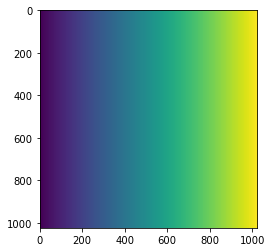

In [3]:
# Understanding Numba Code

import numpy
from numba import cuda

def escape_time(p, maxtime):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.
    """
    z = 0j
    for i in range(maxtime):
        z = z ** 2 + p
        if abs(z) > 2:
            return i
    return maxtime

escape_time_gpu = cuda.jit(device=True)(escape_time)

@cuda.jit
def mandelbrot_gpu(M, real_min, real_max, imag_min, imag_max):
    """Calculate the Mandelbrot set on the GPU.
    
    Parameters
    ----------
    M : numpy.ndarray
        a two-dimensional integer array that will contain the 
        escape times for each point.
    real_min: float
        minimum value on the real axis
    real_max: float
        maximum value on the real axis
    imag_min: float
        minimum value on the imaginary axis
    imag_max: float
        maximum value on the imaginary axis
    """
    ny, nx = M.shape
    i, j = cuda.grid(2)
    
    if i < ny and j < nx:
        dx = (real_max - real_min) / nx
        dy = (imag_max - imag_min) / ny
        p = real_min + dx * i + (imag_min + dy * j) * 1j
        M[i, j] = j#escape_time_gpu(p, 20)
        
        
M = numpy.zeros((1024, 1024), dtype=numpy.int32)
block = (32, 32)
grid = (M.shape[0] // block[0] if M.shape[0] % block[0] == 0 
            else M.shape[0] // block[0] + 1,
        int(M.shape[0] // block[1] if M.shape[1] % block[1] == 0 
            else M.shape[1] // block[1] + 1))


mandelbrot_gpu[grid, block](M, -2.0, 2.0, -1.6, 1.6)

plt.imshow(M, interpolation="nearest")


In [717]:
# Predicted Value from Regression Model is

a = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_normal8_1.raw', dtype='float32')
a = np.reshape(a, [58, 1280, 3200])

d = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_-0.1_1_anistropic_three8_1.raw', dtype='float32')
d = np.reshape(d, [58, 1280, 3200])

Y_array = d
X_array = a

ind_z = 43
ind_y = 1000
ind_x = 2200

tx = X_array[ind_z-2:ind_z+3, ind_y-2:ind_y+3, ind_x-2:ind_x+3]
ty = Y_array[ind_z,           ind_y, ind_x]

X_test = np.array([tx.flatten()])
print(X_test.shape)

tp1 = np.dot(X_test, regr.coefs_[0])
tp2 = tp1 + regr.intercepts_[0]
tp3 = np.tanh(tp2)

print(tp3.shape, regr.coefs_[1].shape, regr.intercepts_[1].shape)

tp4 = np.dot(tp3, regr.coefs_[1])
tp4 = tp4 + regr.intercepts_[1]

print('Predicted Value From Model is ', tp4)
print('Ground Truth Value is         ', ty)
print(X_array[ind_z,           ind_y, ind_x])

(1, 125)
(1, 25) (25, 1) (1,)
Predicted Value From Model is  [[0.02117195]]
Ground Truth Value is          0.021088189
0.0209226


In [718]:
e = np.fromfile('/media/pranjal/BackupPlus/REAL-DBT-PROJECTIONS/RECONS-HUBER/xiaoyu_data-LE-L-CC_3200x1280x58.0_0_0.0005_0_1_anistropic_result8_a_1.raw', dtype='float32')
e = np.reshape(e, [58, 1280, 3200])

In [722]:
print(e[27, 1152, 1315])
print(d[27, 1152, 1315])
print(d[27, 1152, 1315] - e[27, 1152, 1315])

0.039948188
0.04013158
0.00018339232


In [2]:
import numba
from numba import njit, prange
from numba import cuda

In [10]:
# Define the dimensions of the volume
IMGSIZx = 3200
IMGSIZy = 1280
IMGSIZz = 58

# Cuda Kernel to calculate mean of neighboring voxels for each voxel
@cuda.jit(debug=True)
def calculate_mean(outbuf, inbuf):
    # Calculate the index of the voxel being considered
    
    ind_x, ind_y, ind_z = cuda.grid(3)
    #ind_x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    #ind_y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    #ind_z = cuda.blockIdx.z * cuda.blockDim.z + cuda.threadIdx.z
    
    if ind_x < 0 or  ind_y < 0 or  ind_z < 0:
        return
    
    if ind_x > IMGSIZx-1 or ind_y > IMGSIZy-1 or ind_z > IMGSIZz-1:
        return
    
    sum1    = 0.0
    counter = 0
    for ind_nr_z in range(ind_z-2, ind_z+3):
        for ind_nr_y in range(ind_y-2, ind_y+3):
            for ind_nr_x in range(ind_x-2, ind_x+3):
                if ind_nr_x<0 or ind_nr_y<0 or ind_nr_z<0:
                    continue
                
                if ind_nr_x>(IMGSIZx-1) or ind_nr_y>(IMGSIZy-1) or ind_nr_z>(IMGSIZz-1):
                    continue
                
                sum1    = sum1 + inbuf[ind_nr_z, ind_nr_y, ind_nr_x]
                counter = counter+1
    
    outbuf[ind_z, ind_y, ind_x] = sum1/counter
    return


# Create random input matrix for which to calculate voxel wise mean
inbuf = np.random.rand(58, 1280, 3200)
# Create output matrix to store the output 
outbuf  = np.zeros((58, 1280, 3200), np.float32)



# Code to Launch the Cuda kernel in Numba
# 8*400 = 3200 = IMGSIZx
# 8*160 = 1280 = IMGSIZy
# 2*29  = 58   = IMGSIZz
THREADS_PER_BLOCK = (8, 8, 2)
BLOCKS_PER_GRID   = (400, 160, 29)
calculate_mean[BLOCKS_PER_GRID, THREADS_PER_BLOCK](outbuf, inbuf)
cuda.synchronize()



# Checking result for a random voxel (c_z, c_y, c_x)
c_x = random.randint(0, IMGSIZx)
c_y = random.randint(0, IMGSIZy)
c_z = random.randint(0, IMGSIZz)
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3])
result_cuda   = outbuf[c_z, c_y, c_x]
print(result_manual, result_cuda)

0.5002435831882374 0.5002436


In [5]:
# Checking result for a random voxel (c_z, c_y, c_x)
c_x = random.randint(0, IMGSIZx)
c_y = random.randint(0, IMGSIZy)
c_z = random.randint(0, IMGSIZz)
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3])
result_cuda   = outbuf[c_z, c_y, c_x]
print(result_manual, result_cuda)

0.4530233603179261 0.45302337


In [6]:
print(c_x, c_y, c_z)

84 542 22


In [7]:
result_manual = np.mean(inbuf[c_z-2:c_z+3,c_y-2:c_y+3,c_x-2:c_x+3].flatten())

In [8]:
print(result_manual)

0.4530233603179261
